# Machine Learning & Deep Learning Model Building

In [177]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.sql.functions import lag
from pyspark.sql.functions import avg
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import abs, col
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import sum as _sum
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [178]:
# Set up Spark sessions
spark = SparkSession.builder \
    .appName("Beverage Sales Forecasting") \
    .getOrCreate()

In [179]:
data = spark.read.csv('cleaned_data.csv', header=True, inferSchema=True)
data.show(10)

+-------+----------+-----+-------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+-------------------+----------------------------+----+-------+-----+---+----+
|Product|      date|Sales| Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS| Sales_standardized|Google_Mobility_standardized|Year|Quarter|Month|Day|Week|
+-------+----------+-----+-------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+-------------------+----------------------------+----+-------+-----+---+----+
|   SKU1|2017-02-05|27750|                0.0|             0|              0|              0|            0.0|         0|    0|     0|        0| 0.3508801528445185|        -0.42047628698054745|2017|      1|    2|  5|   5|
|   SKU1|2017-02-12|29023|                0.0|             1|              0|              1|            0.0|       

In [180]:
# Drop standardized columns
columns_to_drop = ['Sales_standardized', 'Google_Mobility_standardized']
data = data.drop(*columns_to_drop)
data

DataFrame[Product: string, date: date, Sales: int, Price Discount (%): double, In-Store Promo: int, Catalogue Promo: int, Store End Promo: int, Google_Mobility: double, Covid_Flag: int, V_DAY: int, EASTER: int, CHRISTMAS: int, Year: int, Quarter: int, Month: int, Day: int, Week: int]

In [181]:
# Feature Engineering: Implement Time Lags
windowSpec = Window.partitionBy("Product").orderBy("date")
data = data.withColumn("lag_1_week", lag("Sales", 1).over(windowSpec))
data = data.withColumn("lag_2_weeks", lag("Sales", 2).over(windowSpec))
data = data.withColumn("lag_1_month", lag("Sales", 4).over(windowSpec))

In [182]:
# Feature Engineering: Implement Moving Averages
# Moving average for the past 2 weeks
windowSpec_2w = Window.partitionBy("Product").orderBy("date").rowsBetween(-1, 0)
data = data.withColumn("ma_2_weeks", avg("Sales").over(windowSpec_2w))

# Moving average for the past 4 weeks
windowSpec_4w = Window.partitionBy("Product").orderBy("date").rowsBetween(-3, 0)
data = data.withColumn("ma_4_weeks", avg("Sales").over(windowSpec_4w))

In [183]:
# Fill NULL values in lag columns with zeros
data = data.fillna({
    'lag_1_week': 0, 
    'lag_2_weeks': 0, 
    'lag_1_month': 0
})

data.select("date", "Product", "Sales", "lag_1_week", "lag_2_weeks", "lag_1_month", "ma_2_weeks", "ma_4_weeks").show()

+----------+-------+------+----------+-----------+-----------+----------+------------------+
|      date|Product| Sales|lag_1_week|lag_2_weeks|lag_1_month|ma_2_weeks|        ma_4_weeks|
+----------+-------+------+----------+-----------+-----------+----------+------------------+
|2017-02-05|   SKU1| 27750|         0|          0|          0|   27750.0|           27750.0|
|2017-02-12|   SKU1| 29023|     27750|          0|          0|   28386.5|           28386.5|
|2017-02-19|   SKU1| 45630|     29023|      27750|          0|   37326.5|34134.333333333336|
|2017-02-26|   SKU1| 26789|     45630|      29023|          0|   36209.5|           32298.0|
|2017-03-05|   SKU1| 41999|     26789|      45630|      27750|   34394.0|          35860.25|
|2017-03-12|   SKU1| 29731|     41999|      26789|      29023|   35865.0|          36037.25|
|2017-03-19|   SKU1| 27365|     29731|      41999|      45630|   28548.0|           31471.0|
|2017-03-26|   SKU1| 27722|     27365|      29731|      26789|   27543

In [184]:
data

DataFrame[Product: string, date: date, Sales: int, Price Discount (%): double, In-Store Promo: int, Catalogue Promo: int, Store End Promo: int, Google_Mobility: double, Covid_Flag: int, V_DAY: int, EASTER: int, CHRISTMAS: int, Year: int, Quarter: int, Month: int, Day: int, Week: int, lag_1_week: int, lag_2_weeks: int, lag_1_month: int, ma_2_weeks: double, ma_4_weeks: double]

In [185]:
# Vector Assembly and Scaling
assembler = VectorAssembler(
    inputCols=["Price Discount (%)", "In-Store Promo", "Catalogue Promo", "Store End Promo",
               "Covid_Flag", "V_DAY", "EASTER", "CHRISTMAS", "Google_Mobility", 
               "Year", "Quarter", "Month", "Day", "Week", "lag_1_week", "lag_2_weeks", "lag_1_month", "ma_2_weeks", "ma_4_weeks"],
    outputCol="features_initial")

data = assembler.transform(data)
scaler = StandardScaler(inputCol="features_initial", outputCol="features", withStd=True, withMean=True)
data = scaler.fit(data).transform(data)

In [186]:
# Filter for Q3 and Q4 of 2020 for testing
test_data = data.filter((col("date") >= "2020-07-01") & (col("date") <= "2020-12-31"))

# Filter data for training
train_data = data.filter((col("date") < "2020-07-01") | (col("date") > "2020-12-31"))

# Check the date range
train_data.agg({"date": "min"}).show()
train_data.agg({"date": "max"}).show()
test_data.agg({"date": "min"}).show()
test_data.agg({"date": "max"}).show()

+----------+
| min(date)|
+----------+
|2017-02-05|
+----------+

+----------+
| max(date)|
+----------+
|2020-06-28|
+----------+

+----------+
| min(date)|
+----------+
|2020-07-05|
+----------+

+----------+
| max(date)|
+----------+
|2020-12-27|
+----------+



In [187]:
def trainsform_train (product):
# Fetch and prepare data
    time_series_data = train_data.filter(train_data['Product'] == product).select("date", "Sales").orderBy("date")
    time_series_pd = time_series_data.toPandas()
    time_series_pd.set_index('date', inplace=True)

    return time_series_pd

In [188]:
def trainsform_test (product):
# Fetch and prepare test data
    time_series_test = test_data.select("date", "Sales").filter(data['Product'] == product).orderBy("date")
    time_series_test = time_series_test.toPandas()
    time_series_test.set_index('date', inplace=True)

    return time_series_test

In [189]:
products = data.select('Product').distinct().orderBy(col("Product")).collect()

## Linear Regression

In [190]:
# Build Linear Regression Model
lr = LinearRegression(featuresCol='features', labelCol='Sales')
lr_model = lr.fit(train_data)

In [191]:
# Prediction and Evaluation
lr_predictions = lr_model.transform(test_data)

lr_error = lr_predictions.withColumn("Absolute_Error", abs(col("Sales") - col("prediction")))
lr_actual = lr_predictions.select(_sum("Sales")).first()[0]
lr_error_sum = lr_error.select(_sum("Absolute_Error")).first()[0]

lr_wt_mape = lr_error_sum / lr_actual
lr_accuracy = 1 - lr_wt_mape

print(f"Linear Regression Model Forecast Accuracy: {lr_accuracy}")

Linear Regression Model Forecast Accuracy: 0.9880628354129395


In [192]:
def lr_plotting (product):
    time_series_pd = trainsform_train(product)
    time_series_test = trainsform_test(product)

# Fetch and prepare prediction data
    time_series_prediction = lr_predictions.filter(lr_predictions['Product'] == product).select("date", "prediction").orderBy("date")
    time_series_prediction = time_series_prediction.toPandas()
    time_series_prediction.set_index('date', inplace=True)

# Visualize the forecast
    plt.figure(figsize=(10, 5))
    plt.plot(time_series_pd.index, time_series_pd['Sales'], label='Observed')
    plt.plot(time_series_test.index, time_series_test['Sales'], color='lightgreen', linewidth=3, label='Test')
    plt.plot(time_series_prediction.index, time_series_prediction['prediction'], color='red', label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Linear Regression Forecast for {product}')
    plt.legend()
    plt.savefig(f'Linear Regression Forecast for {product}.png')
    plt.show()

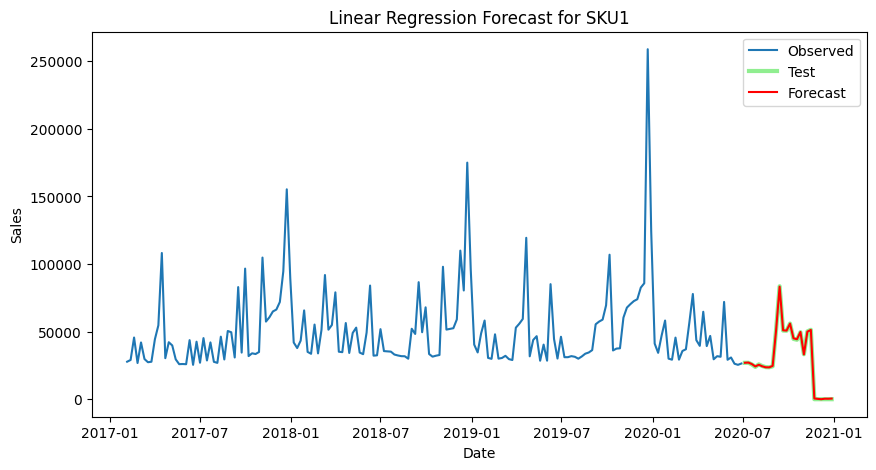

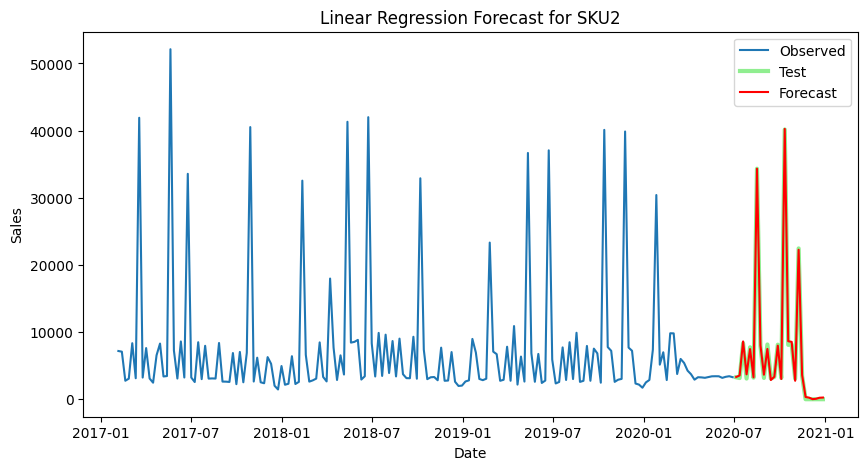

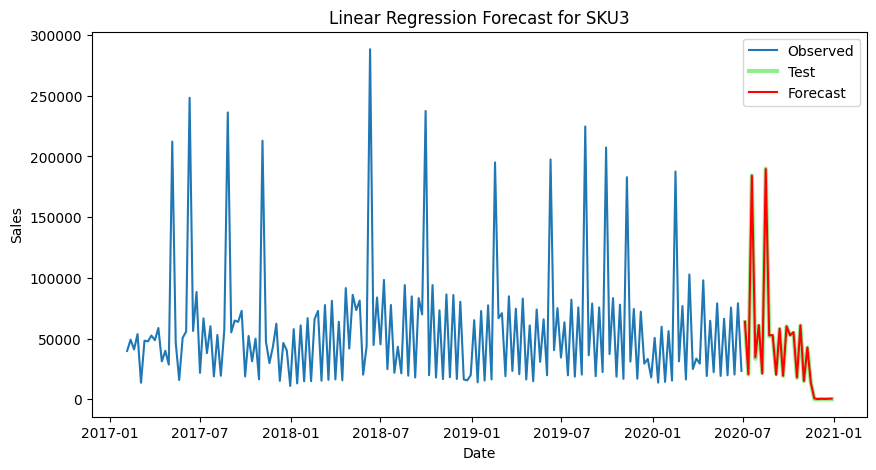

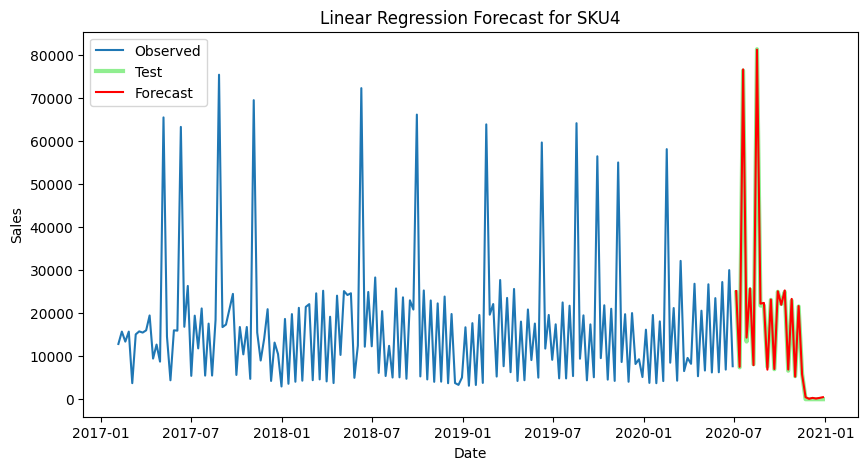

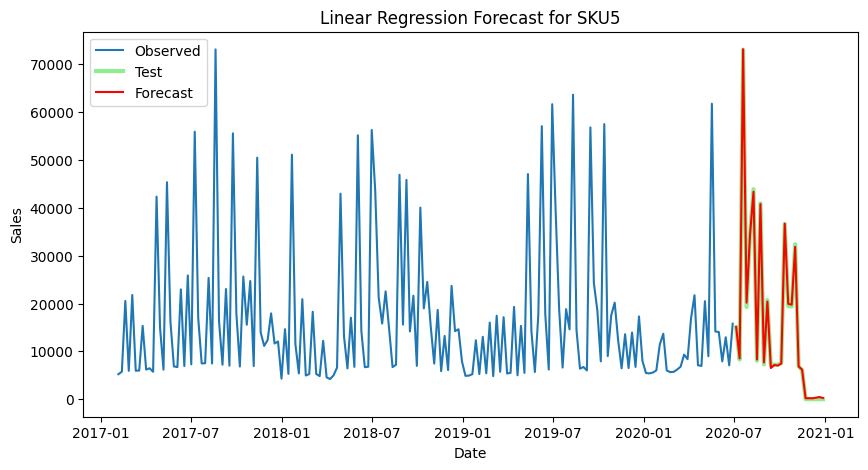

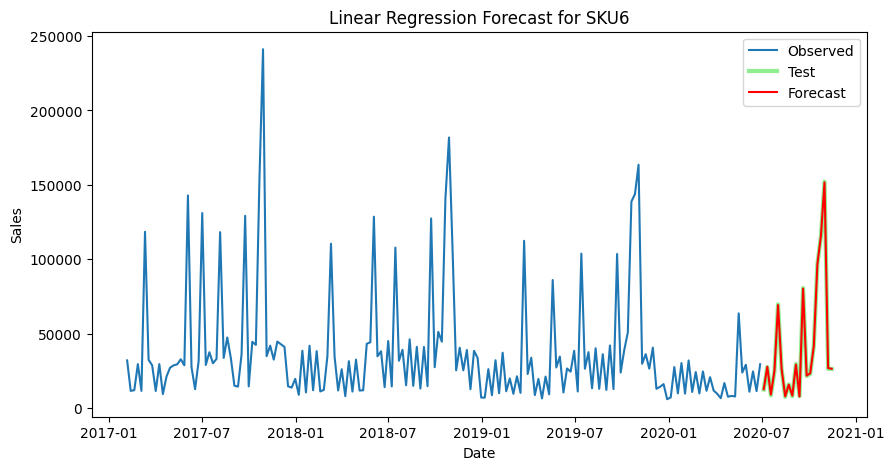

In [253]:
for row in products:
    product_name = row.Product  # Extract the product name from the Row object
    lr_plotting(product_name)

## Decision Tree

In [194]:
# Build decision tree model
dt = DecisionTreeRegressor(featuresCol='features', labelCol='Sales')
dt_model = dt.fit(train_data)

In [195]:
# Prediction and Evaluation
dt_predictions = dt_model.transform(test_data)

dt_error = dt_predictions.withColumn("Absolute_Error", abs(col("Sales") - col("prediction")))
dt_actual = dt_predictions.select(_sum("Sales")).first()[0]
dt_error_sum = dt_error.select(_sum("Absolute_Error")).first()[0]

dt_wt_mape = dt_error_sum / dt_actual
dt_accuracy = 1 - dt_wt_mape

print(f"Decision Tree Model Forecast Accuracy: {dt_accuracy}")

Decision Tree Model Forecast Accuracy: 0.4843493291150738


In [196]:
def dt_plotting (product):
    time_series_pd = trainsform_train(product)
    time_series_test = trainsform_test(product)

# Fetch and prepare prediction data
    time_series_prediction = dt_predictions.filter(dt_predictions['Product'] == product).select("date", "prediction").orderBy("date")
    time_series_prediction = time_series_prediction.toPandas()
    time_series_prediction.set_index('date', inplace=True)

# Visualize the forecast
    plt.figure(figsize=(10, 5))
    plt.plot(time_series_pd.index, time_series_pd['Sales'], label='Observed')
    plt.plot(time_series_test.index, time_series_test['Sales'], color='lightgreen', linewidth=3, label='Test')
    plt.plot(time_series_prediction.index, time_series_prediction['prediction'], color='red', label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Decision Tree Forecast for {product}')
    plt.legend()
    plt.savefig(f'Decision Tree Forecast for {product}.png')
    plt.show()

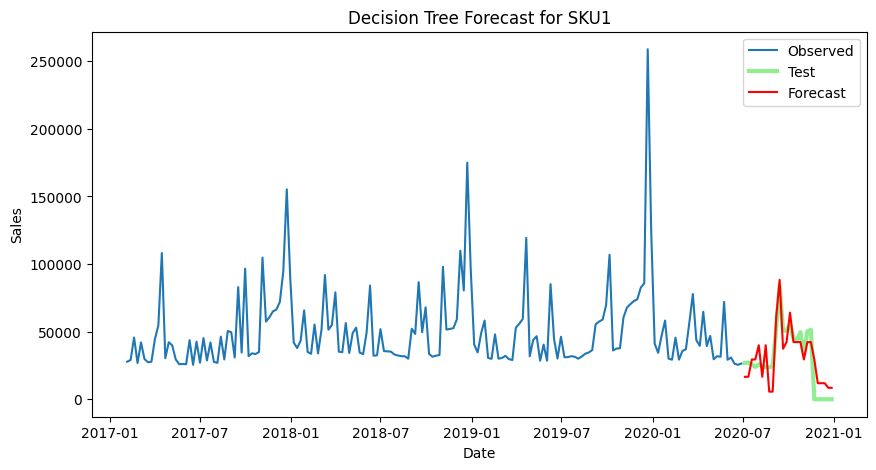

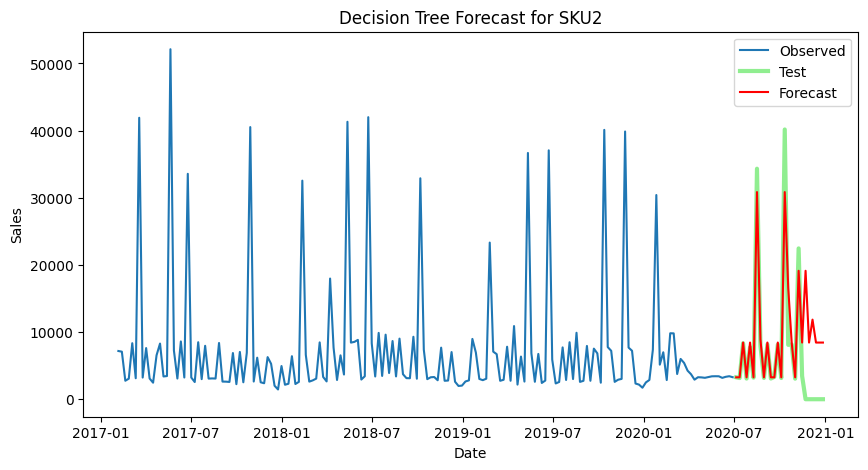

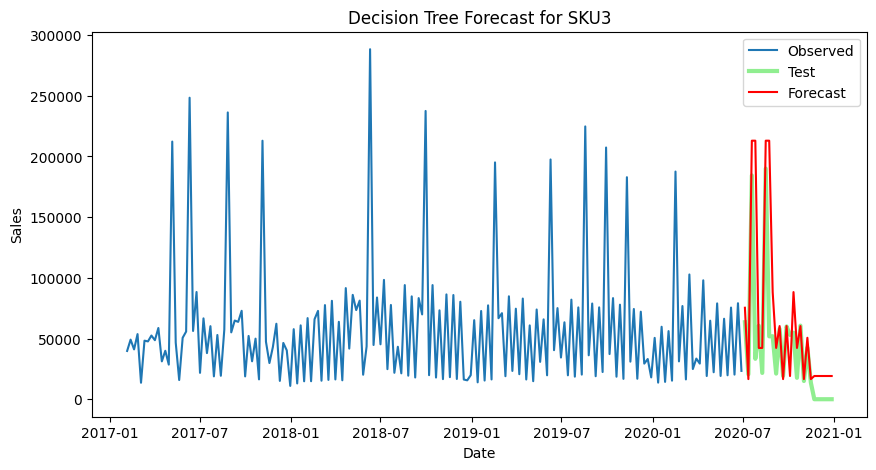

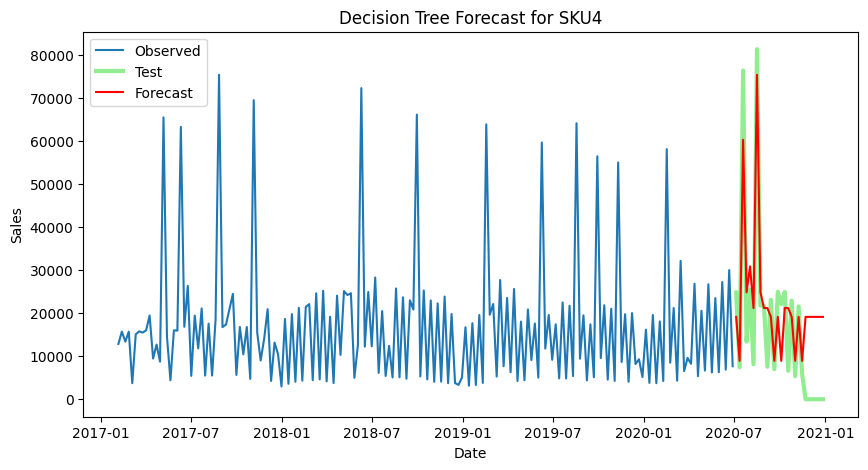

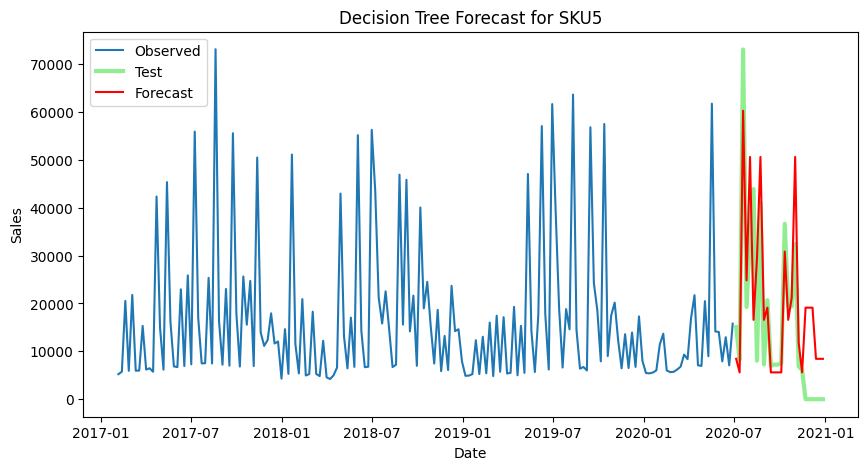

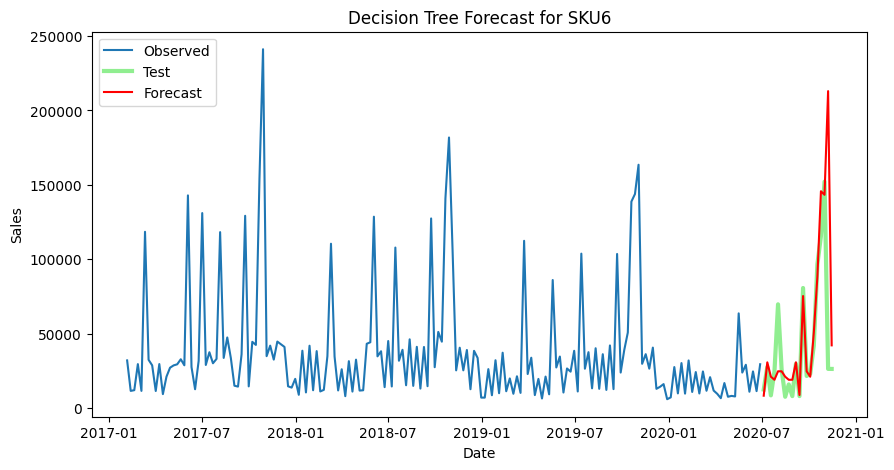

In [197]:
for row in products:
    product_name = row.Product  # Extract the product name from the Row object
    dt_plotting(product_name)

## Gradient-Boosted Trees

In [198]:
# Build Gradient-Boosted Trees model
gbt = GBTRegressor(featuresCol='features', labelCol='Sales', maxIter=10)
gbt_model = gbt.fit(train_data)

In [199]:
# Prediction and Evaluation
gbt_predictions = gbt_model.transform(test_data)

gbt_error = gbt_predictions.withColumn("Absolute_Error", abs(col("Sales") - col("prediction")))
gbt_actual = gbt_predictions.select(_sum("Sales")).first()[0]
gbt_error_sum = gbt_error.select(_sum("Absolute_Error")).first()[0]

gbt_wt_mape = gbt_error_sum / dt_actual
gbt_accuracy = 1 - gbt_wt_mape

print(f"Gradient-Boosted Trees Forecast Accuracy: {gbt_accuracy}")

Gradient-Boosted Trees Forecast Accuracy: 0.5269548552304337


In [224]:
def gbt_plotting (product):
    time_series_pd = trainsform_train(product)
    time_series_test = trainsform_test(product)

# Fetch and prepare prediction data
    time_series_prediction = gbt_predictions.filter(gbt_predictions['Product'] == product).select("date", "prediction").orderBy("date")
    time_series_prediction = time_series_prediction.toPandas()
    time_series_prediction.set_index('date', inplace=True)

# Visualize the forecast
    plt.figure(figsize=(10, 5))
    plt.plot(time_series_pd.index, time_series_pd['Sales'], label='Observed')
    plt.plot(time_series_test.index, time_series_test['Sales'], color='lightgreen', linewidth=3, label='Test')
    plt.plot(time_series_prediction.index, time_series_prediction['prediction'], color='red', label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Gradient-Boosted Trees Forecast for {product}')
    plt.legend()
    plt.savefig(f'Gradient-Boosted Trees Forecast for {product}.png')
    plt.show()

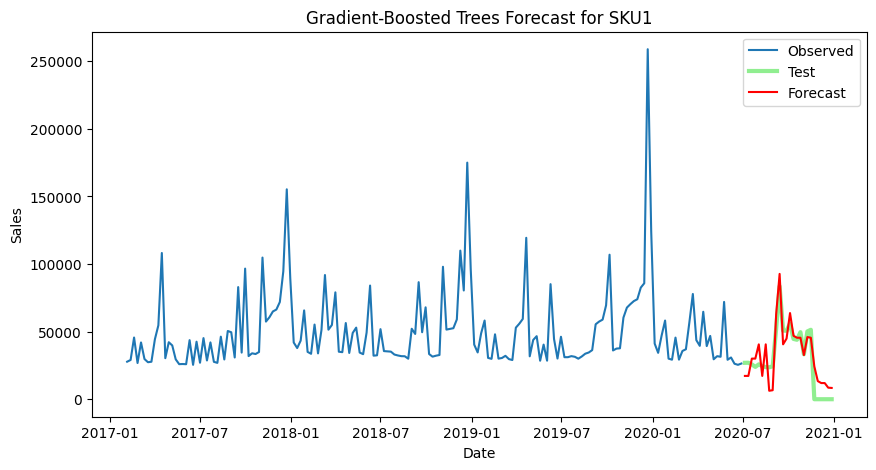

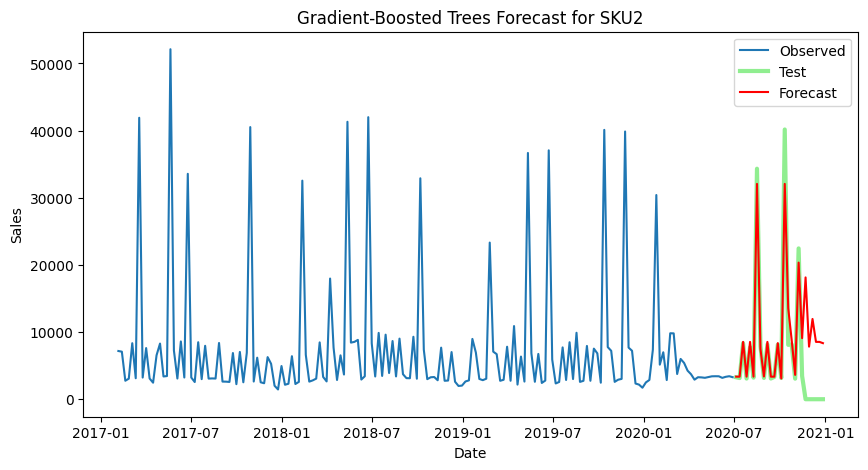

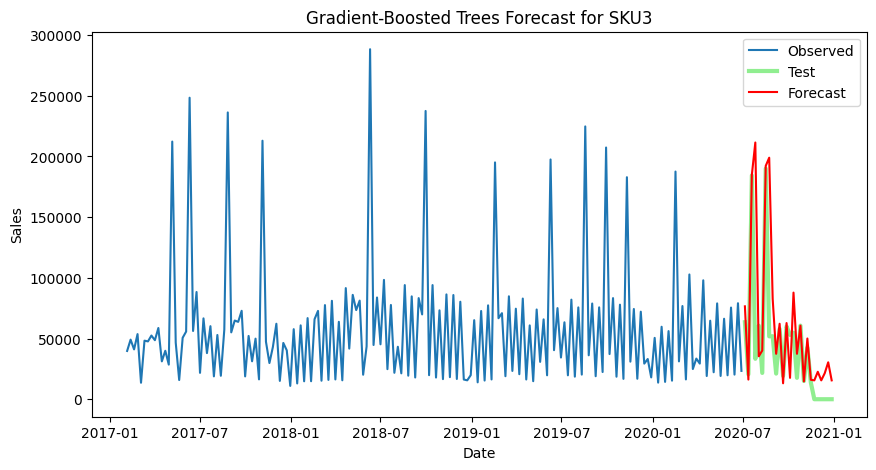

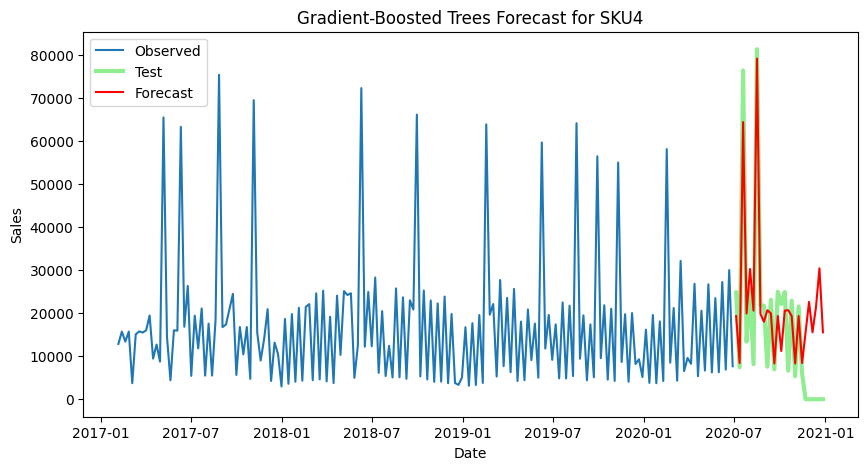

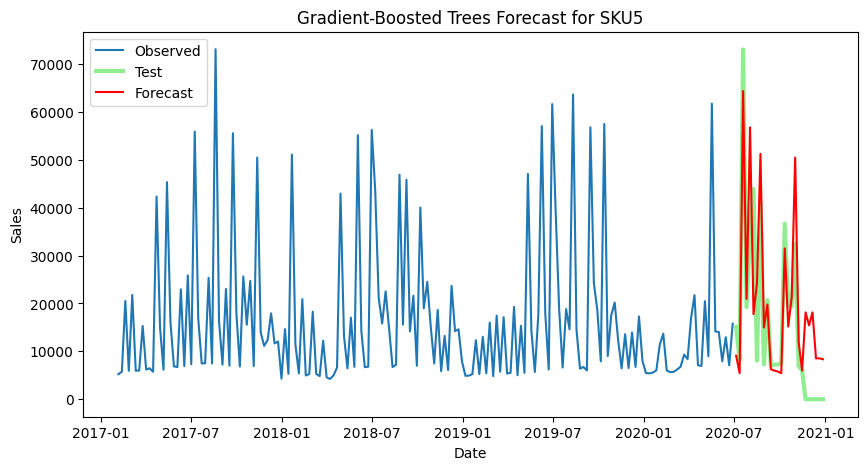

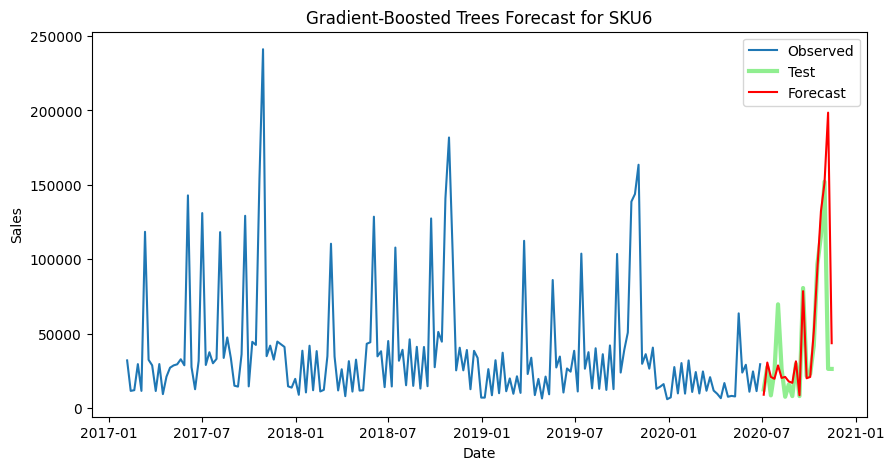

In [225]:
for row in products:
    product_name = row.Product  # Extract the product name from the Row object
    gbt_plotting(product_name)

## LSTM (Long Short-Term Memory) with Keras

In [202]:
# Transform back to pandas dataframe
pandas_df = train_data.select("features", "Sales").toPandas()

# Converts the features and target columns from a pandas DataFrame into NumPy arrays
X_train = np.array(pandas_df['features'].tolist())
y_train = pandas_df['Sales'].values

In [203]:
# Reshape input data for LSTM (samples size, time steps, numbers of variables)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=72)

Epoch 1/20


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2175906816.0000
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2289573632.0000 
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2091392768.0000
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1986019200.0000 
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2224011264.0000  
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2176974336.0000 
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2554323712.0000 
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2281435392.0000 
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2535487744.0000 
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2461434880.0000 
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2222275584.0000 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2376282112.0000 
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2244990976.0000 
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━

In [204]:
# Transform test dataset back to pandas dataframe
pandas_test = test_data.select("features", "Sales").toPandas()

# Converts the features and target columns from a pandas DataFrame into NumPy arrays
X_test = np.array(pandas_test['features'].tolist())
y_test = pandas_test['Sales'].values


# Reshape X_test for LSTM input
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [205]:
# Predictions and Evaluation
y_pred = model.predict(X_test)

lstm_predictions = pd.DataFrame({
    "Actual": y_test.flatten(),  # Flatten y_test if it's multidimensional
    "Predicted": y_pred.flatten()
})


lstm_predictions['Absolute_Error'] = (lstm_predictions['Actual'] - lstm_predictions['Predicted']).abs()
lstm_error_sum = lstm_predictions['Absolute_Error'].sum()
lstm_actual_sum = lstm_predictions['Actual'].sum()

lstm_wt_mape = lstm_error_sum / lstm_actual_sum
lstm_accuracy = 1 - lstm_wt_mape

print(f"LSTM Forecast Accuracy: {lstm_accuracy}")

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D716981B20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
LSTM Forecast Accuracy: 0.00014817055299309878


In [206]:
lstm_predictions

Actual  Predicted  Absolute_Error
0     26925   0.440677    26924.559323
1     26973   1.008394    26971.991606
2     25749   1.771308    25747.228692
3     23891   3.180339    23887.819661
4     25792  -0.403963    25792.403963
..      ...        ...             ...
145   96619  12.901265    96606.098735
146  115798  16.985817   115781.014183
147  152186  22.384888   152163.615112
148   26445  21.238548    26423.761452
149   26414  19.459333    26394.540667

[150 rows x 3 columns]

In [207]:
test_pd = test_data.toPandas()
lstm_predictions['Product'] = test_pd['Product']
lstm_predictions['date'] = test_pd['date']
lstm_predictions

Actual  Predicted  Absolute_Error Product        date
0     26925   0.440677    26924.559323    SKU1  2020-07-05
1     26973   1.008394    26971.991606    SKU1  2020-07-12
2     25749   1.771308    25747.228692    SKU1  2020-07-19
3     23891   3.180339    23887.819661    SKU1  2020-07-26
4     25792  -0.403963    25792.403963    SKU1  2020-08-02
..      ...        ...             ...     ...         ...
145   96619  12.901265    96606.098735    SKU6  2020-10-18
146  115798  16.985817   115781.014183    SKU6  2020-10-25
147  152186  22.384888   152163.615112    SKU6  2020-11-01
148   26445  21.238548    26423.761452    SKU6  2020-11-08
149   26414  19.459333    26394.540667    SKU6  2020-11-15

[150 rows x 5 columns]

In [226]:
def lstm_plotting (product):
    time_series_pd = trainsform_train(product)
    time_series_test = trainsform_test(product)

# Fetch and prepare prediction data
    time_series_prediction = lstm_predictions[lstm_predictions['Product'] == product]
    time_series_prediction.set_index('date', inplace=True)

# Visualize the forecast
    plt.figure(figsize=(10, 5))
    plt.plot(time_series_pd.index, time_series_pd['Sales'], label='Observed')
    plt.plot(time_series_test.index, time_series_test['Sales'], color='lightgreen', linewidth=3, label='Test')
    plt.plot(time_series_prediction.index, time_series_prediction['Predicted'], color='red', label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'LSTM (Long Short-Term Memory) with Keras Model Forecast for {product}')
    plt.legend()
    plt.savefig(f'LSTM (Long Short-Term Memory) with Keras Model for {product}.png')
    plt.show()

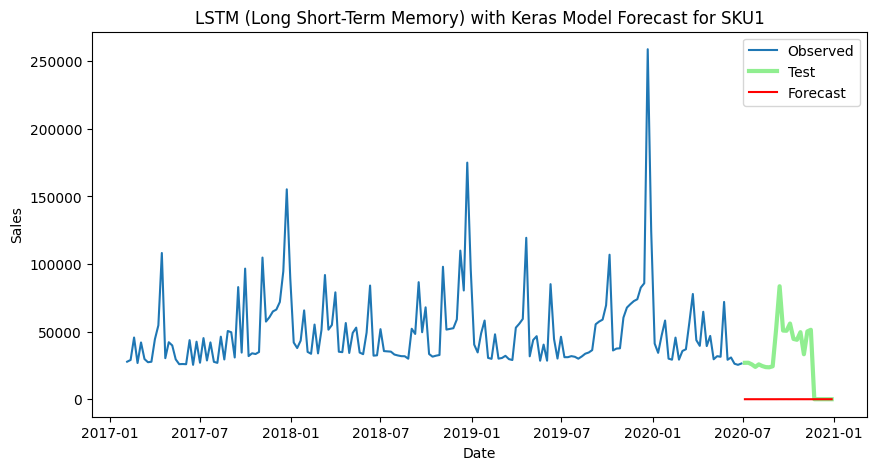

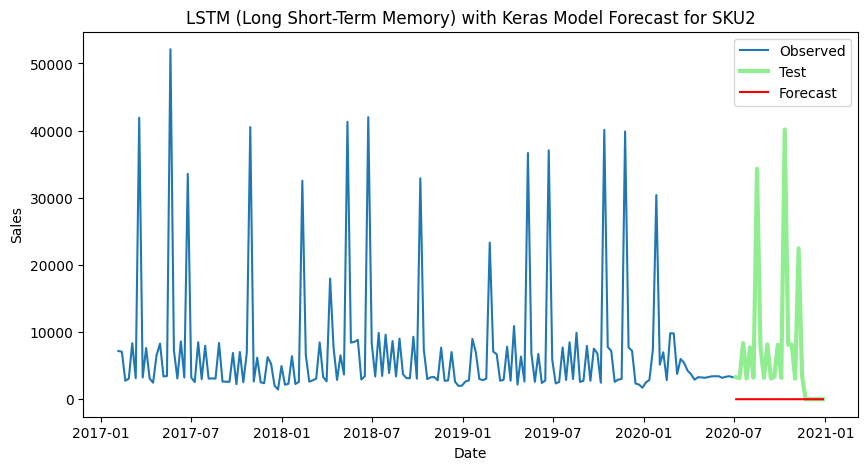

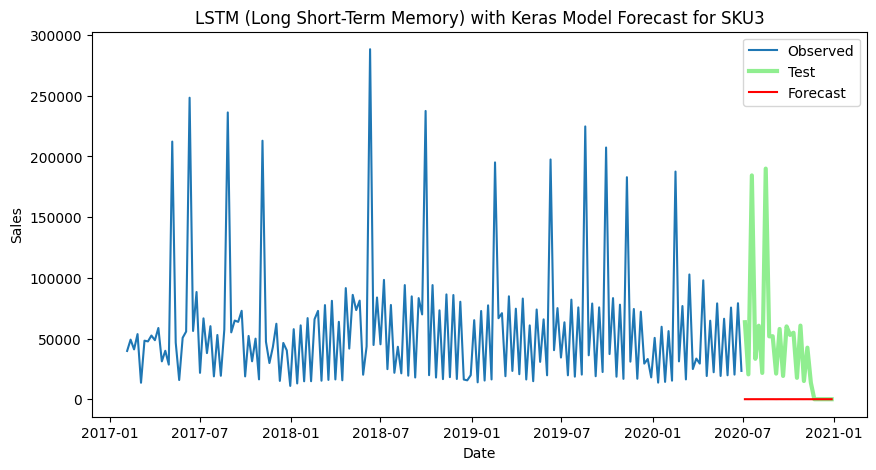

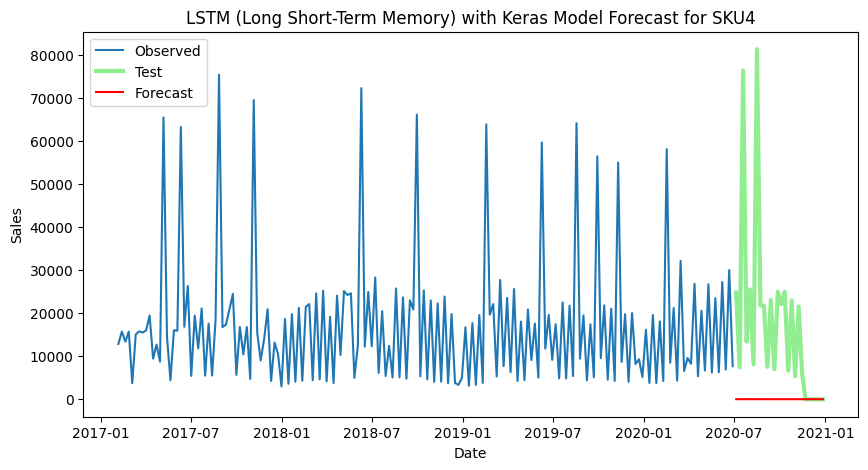

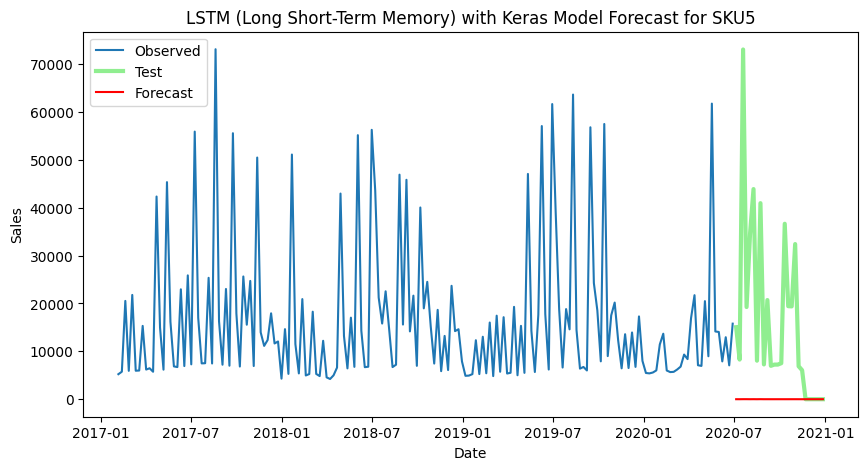

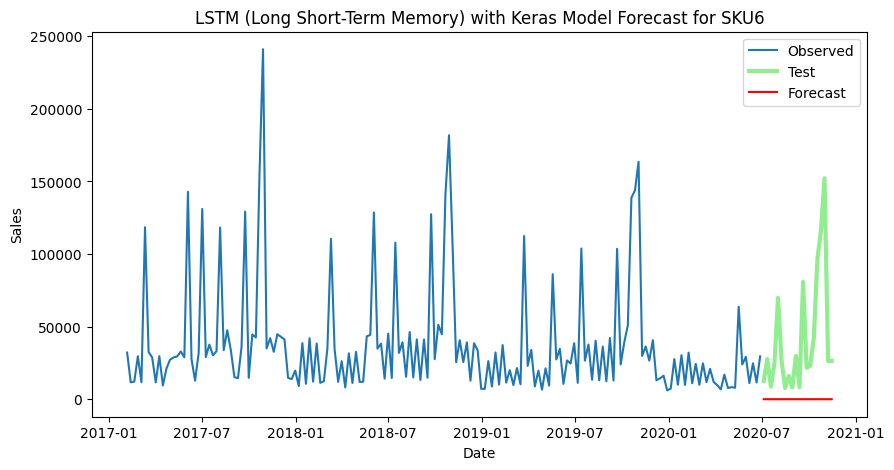

In [227]:
for row in products:
    product_name = row.Product  # Extract the product name from the Row object
    lstm_plotting(product_name)

## ARIMA

In [210]:
def check_stationarity(product):
    # Fetch and prepare data
    time_series_data = train_data.filter(train_data['Product'] == product).select("date", "Sales").orderBy("date")
    time_series_pd = time_series_data.toPandas()
    time_series_pd.set_index('date', inplace=True)

    # ADF test
    result = adfuller(time_series_pd['Sales'].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


    # Perform ADF test on the seasonally differenced data
    time_series_pd['Seasonally_Differenced'] = time_series_pd['Sales'] - time_series_pd['Sales'].shift(52)
    result_ss = adfuller(time_series_pd['Seasonally_Differenced'].dropna())  # Drop NA values that were created by differencing
    print('ADF Statistic for seasonality: %f' % result_ss[0])
    print('p-value for seasonality: %f' % result_ss[1])
    print('Critical Values for seasonality:')
    for key, value in result_ss[4].items():
        print('\t%s: %.3f' % (key, value))


    # Plotting
    fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 16))  
    plot_acf(time_series_pd['Sales'].dropna(), ax=axes[0], lags=160)  
    axes[0].set_title('Autocorrelation Function')

    plot_pacf(time_series_pd['Sales'].dropna(), ax=axes[1], lags=88)  
    axes[1].set_title('Partial Autocorrelation Function')

    axes[2].plot(time_series_pd['Sales'], label='Original')
    axes[2].set_title('Original Sales Data')
    axes[2].legend()

    axes[3].plot(time_series_pd.get('Seasonally_Differenced', pd.Series()), label='Seasonally Differenced', color='orange')
    axes[3].set_title('Seasonally Differenced Sales Data')
    axes[3].legend()

    plot_acf(time_series_pd['Seasonally_Differenced'].dropna(), ax=axes[4], lags=125)
    axes[4].set_title('ACF for Seasonally Differenced Data')
    
    plot_pacf(time_series_pd['Seasonally_Differenced'].dropna(), ax=axes[5], lags=60)
    axes[5].set_title('PACF for Seasonally Differenced Data')

    plt.tight_layout()
    plt.show()

    return time_series_pd

In [231]:
def arima_model(df, product, p, d, q, P, D, Q, s):
    # Fit the ARIMA model
    model = ARIMA(df['Sales'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    fitted_model = model.fit()
    
    # Fetch and prepare test data
    time_series_test = test_data.select("date", "Sales").filter(data['Product'] == product).orderBy("date")
    time_series_test = time_series_test.toPandas()
    time_series_test.set_index('date', inplace=True)
    
    num_forecast_steps = len(time_series_test)  # Number of periods to forecast
    
    # Perform the forecast
    forecast = fitted_model.get_forecast(steps=num_forecast_steps)
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()

    #Evaluation
    mean_forecast_df = mean_forecast.to_frame(name="Sales")
    
    mean_forecast_df['Absolute_Error'] = (time_series_test['Sales'] - mean_forecast_df['Sales']).abs() 
    arima_error_sum = mean_forecast_df['Absolute_Error'].sum()
    arima_actual_sum = time_series_test['Sales'].sum()
    
    arima_wt_mape = arima_error_sum / arima_actual_sum
    arima_accuracy = 1 - arima_wt_mape
    
    print(f"ARIMA for {product} Forecast Accuracy: {arima_accuracy}")
    
    # Visualize the forecast
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Sales'], label='Observed')
    plt.plot(time_series_test.index, time_series_test['Sales'], color='lightgreen', label='Test')
    plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='Forecast')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'ARIMA Forecast for {product}')
    plt.legend()
    plt.savefig(f'ARIMA Forecast for {product}.png')
    plt.show()

    return mean_forecast

ADF Statistic: -8.749850
p-value: 0.000000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
ADF Statistic for seasonality: -9.448932
p-value for seasonality: 0.000000
Critical Values for seasonality:
	1%: -3.484
	5%: -2.885
	10%: -2.579


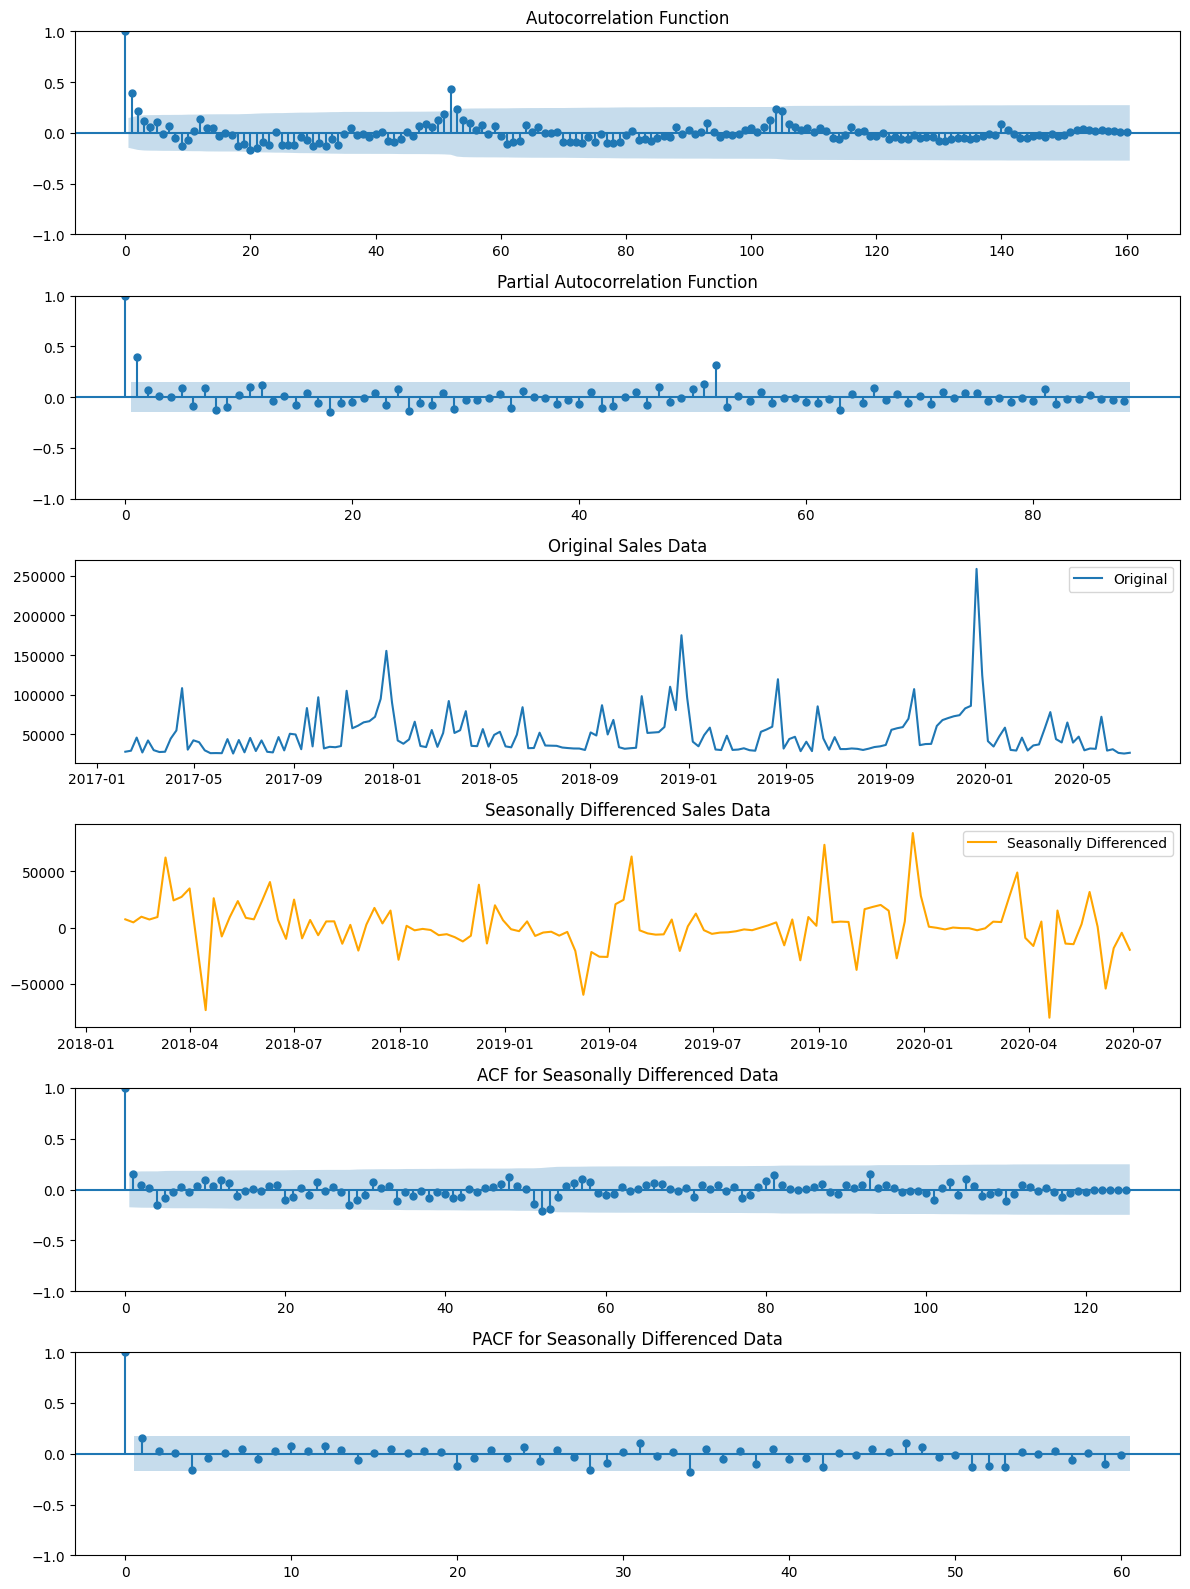

In [212]:
time_series_train_SKU1 = check_stationarity('SKU1')

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


ARIMA for SKU1 Forecast Accuracy: -0.2109739696458175


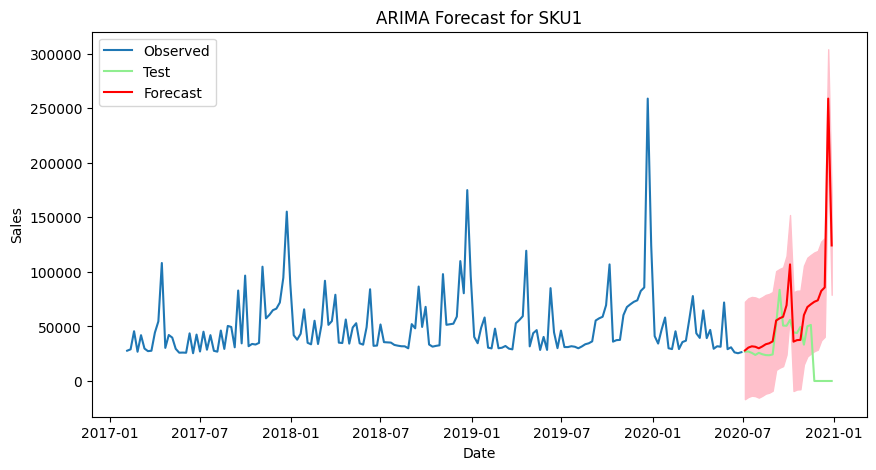

In [233]:
arima_SKU1 = arima_model(time_series_train_SKU1, 'SKU1', 1, 0, 0, 0, 1, 0, 52)

ADF Statistic: -14.239652
p-value: 0.000000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
ADF Statistic for seasonality: -12.896022
p-value for seasonality: 0.000000
Critical Values for seasonality:
	1%: -3.484
	5%: -2.885
	10%: -2.579


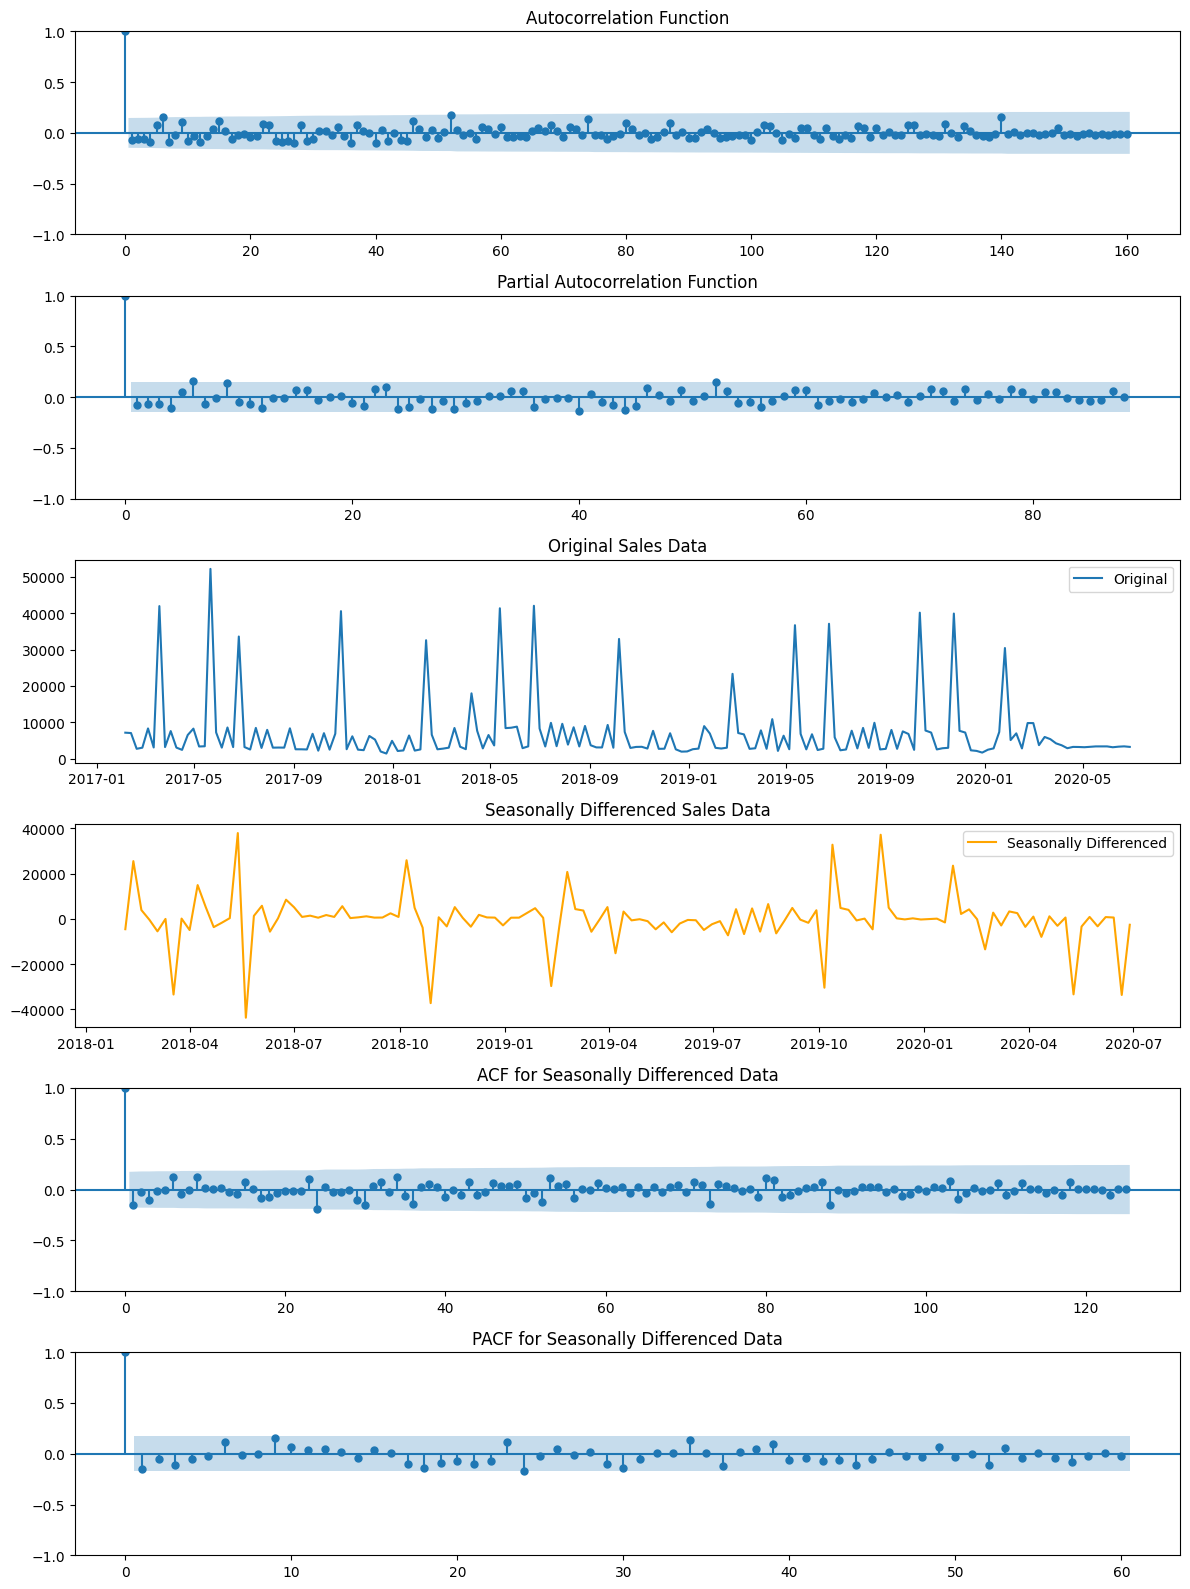

In [214]:
time_series_train_SKU2 = check_stationarity('SKU2')
# Stationary

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


ARIMA for SKU2 Forecast Accuracy: 0.33827900224495155


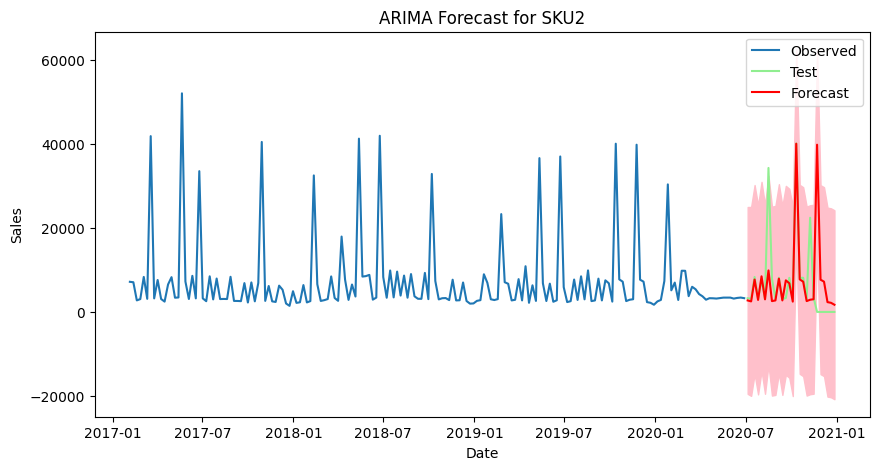

In [234]:
arima_SKU2 = arima_model(time_series_train_SKU2, 'SKU2', 1, 0, 0, 0, 1, 0, 52)

ADF Statistic: -6.336707
p-value: 0.000000
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576
ADF Statistic for seasonality: -6.674686
p-value for seasonality: 0.000000
Critical Values for seasonality:
	1%: -3.486
	5%: -2.886
	10%: -2.580


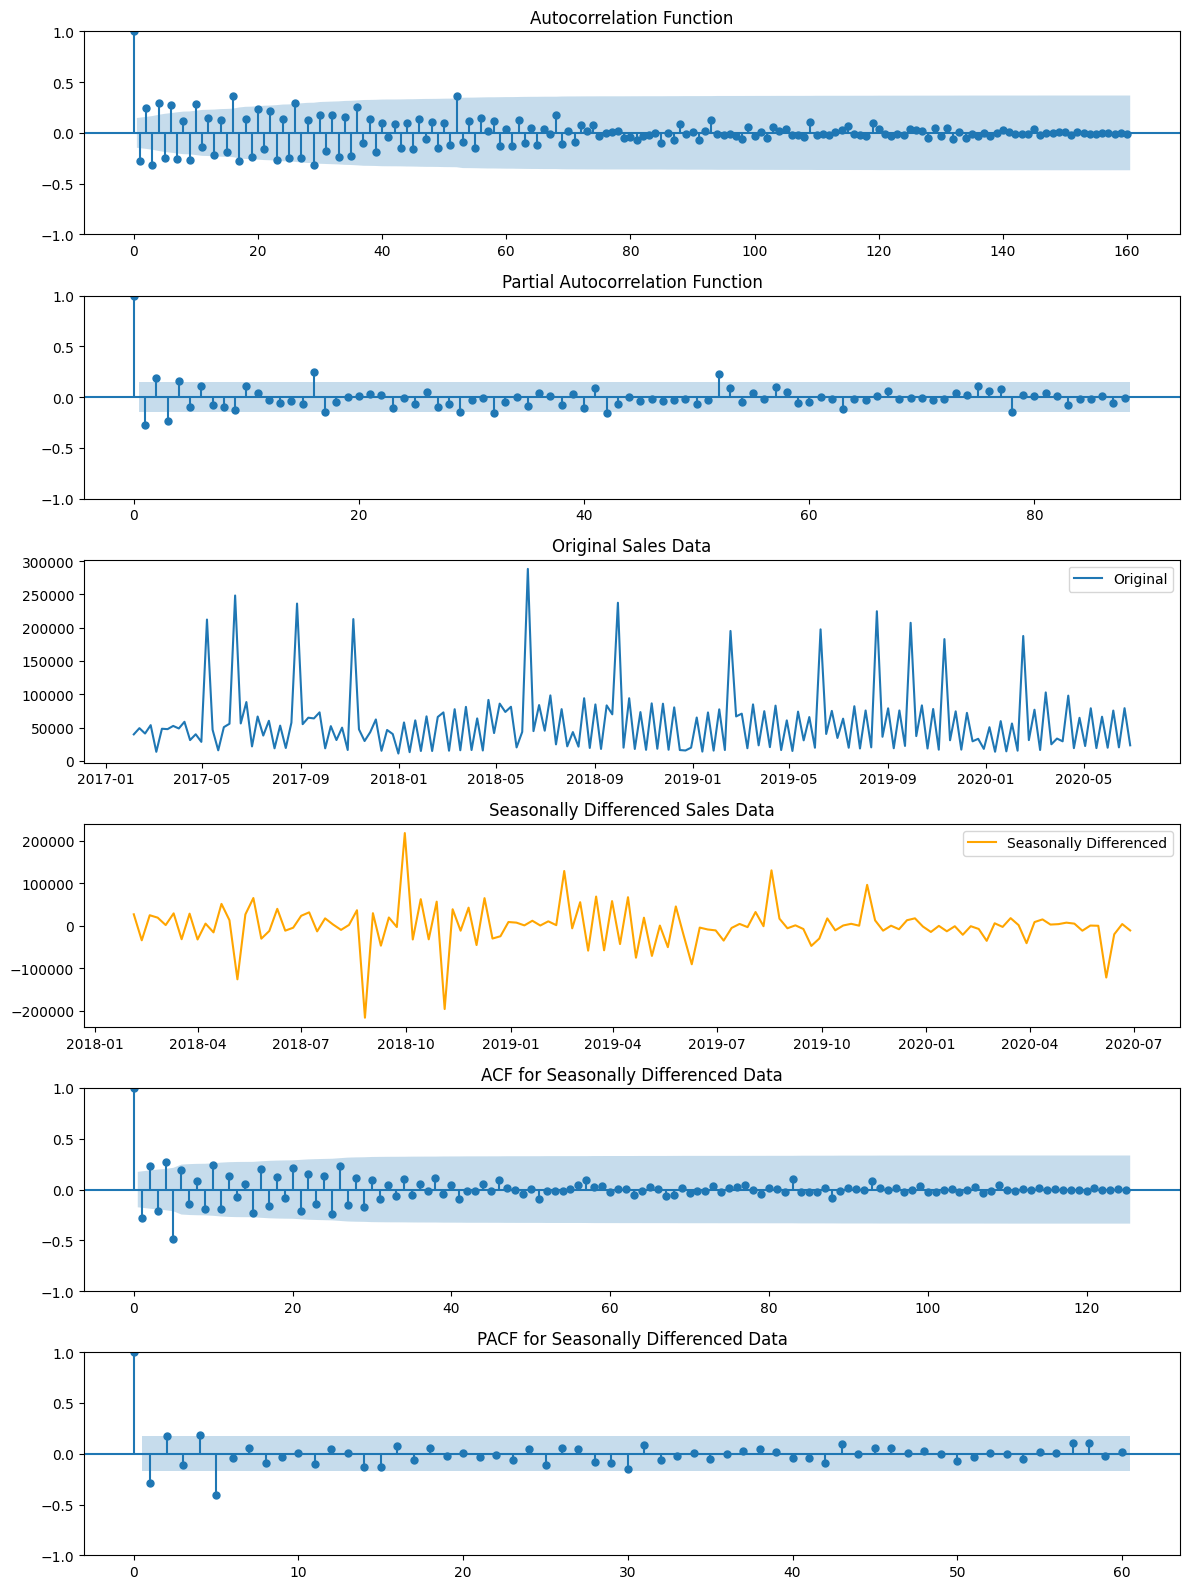

In [216]:
time_series_train_SKU3 = check_stationarity('SKU3')
# Stationary

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


ARIMA for SKU3 Forecast Accuracy: 0.35044006117019577


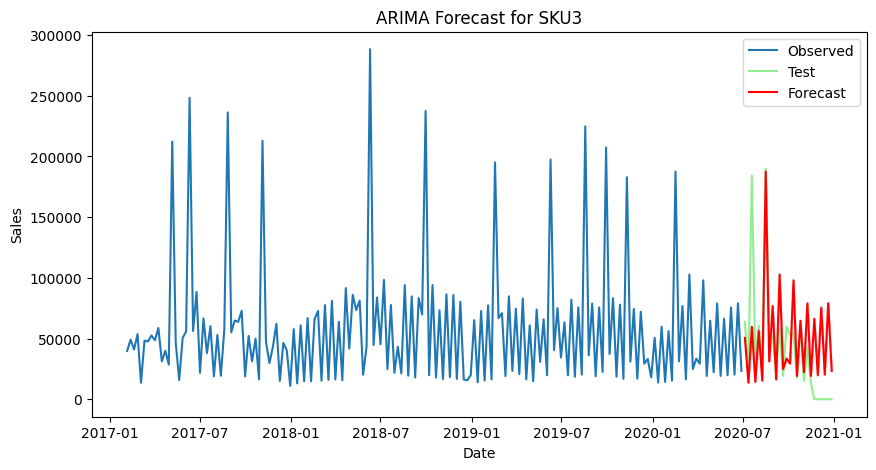

In [235]:
arima_SKU3 = arima_model(time_series_train_SKU3, 'SKU3', 0, 0, 0, 0, 1, 0, 26)

ADF Statistic: -4.702626
p-value: 0.000083
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576
ADF Statistic for seasonality: -6.692131
p-value for seasonality: 0.000000
Critical Values for seasonality:
	1%: -3.486
	5%: -2.886
	10%: -2.580


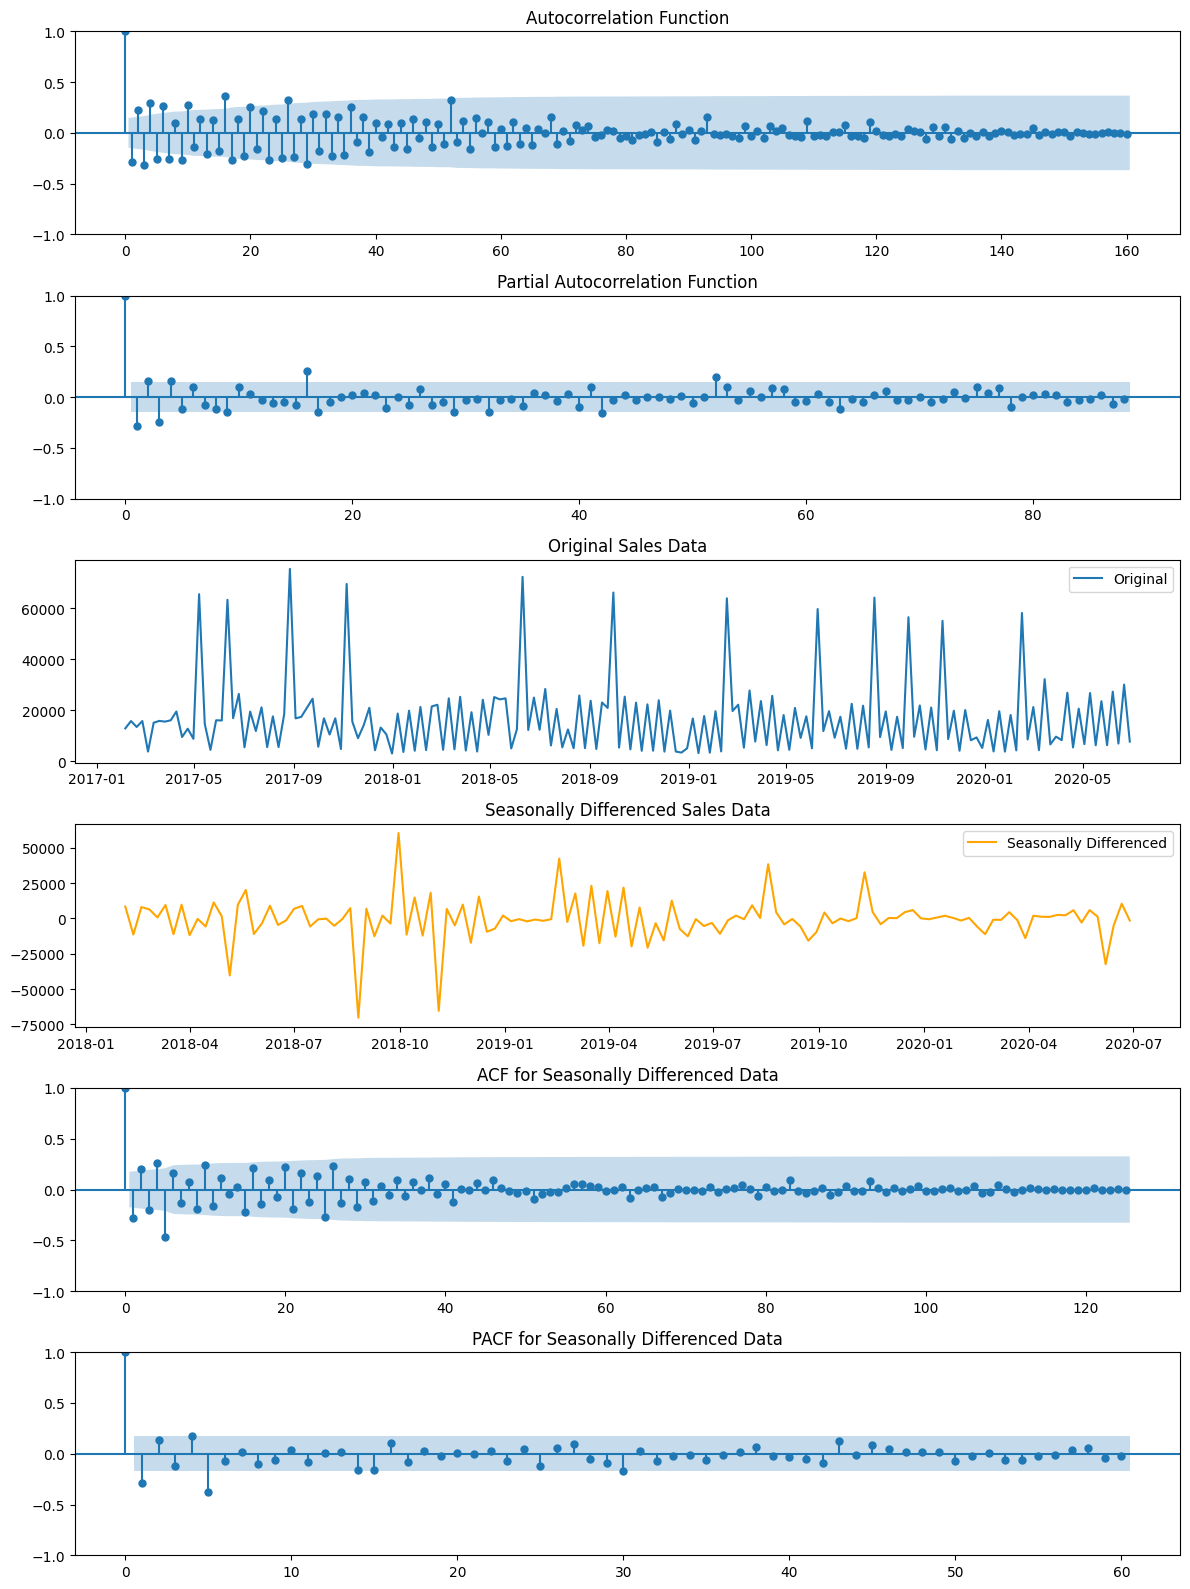

In [218]:
time_series_train_SKU4 = check_stationarity('SKU4')
# Stationary

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


ARIMA for SKU4 Forecast Accuracy: 0.3893058887255282


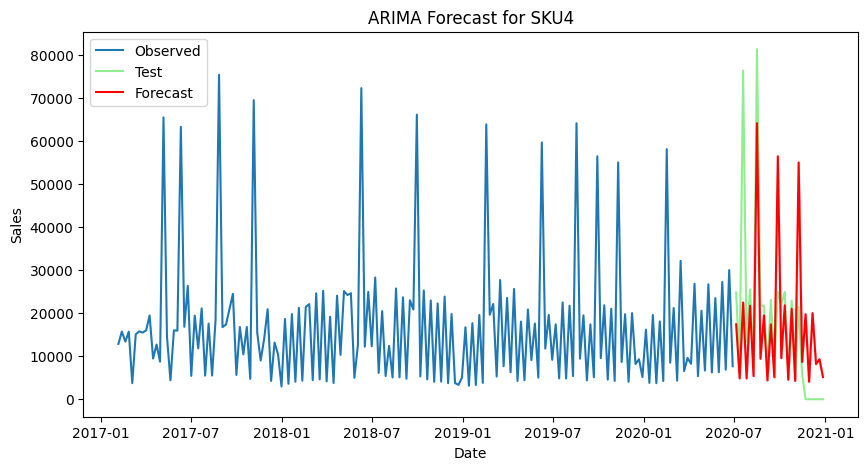

In [236]:
arima_SKU4 = arima_model(time_series_train_SKU4, 'SKU4', 0, 0, 0, 0, 1, 0, 52)

ADF Statistic: -3.586767
p-value: 0.006019
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576
ADF Statistic for seasonality: -9.615911
p-value for seasonality: 0.000000
Critical Values for seasonality:
	1%: -3.485
	5%: -2.885
	10%: -2.579


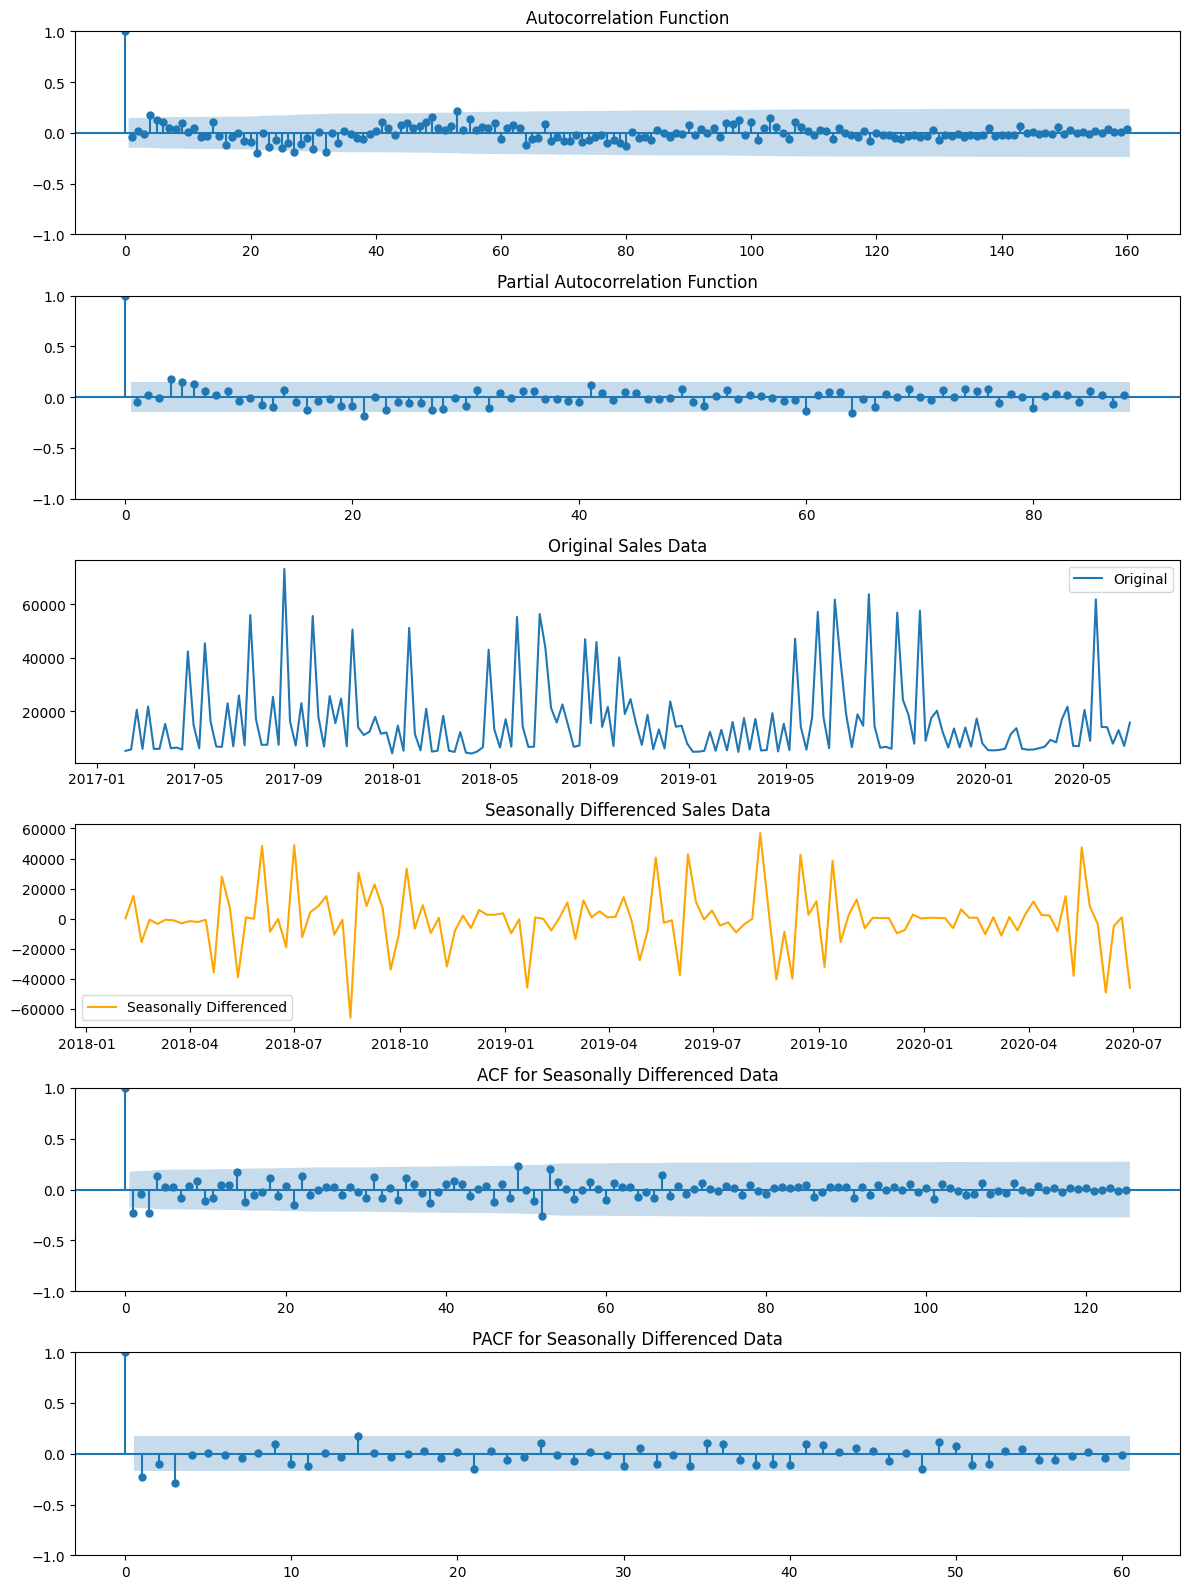

In [220]:
time_series_train_SKU5 = check_stationarity('SKU5')
# Stationary

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


ARIMA for SKU5 Forecast Accuracy: 0.06596035868217087


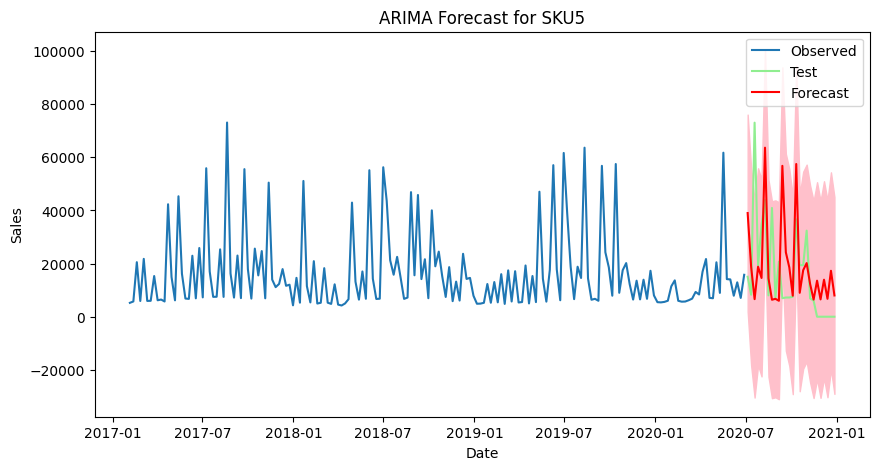

In [237]:
arima_SKU5 = arima_model(time_series_train_SKU5, 'SKU5', 0, 0, 0, 0, 1, 0, 52)

ADF Statistic: -4.968607
p-value: 0.000026
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576
ADF Statistic for seasonality: -9.785631
p-value for seasonality: 0.000000
Critical Values for seasonality:
	1%: -3.485
	5%: -2.885
	10%: -2.579


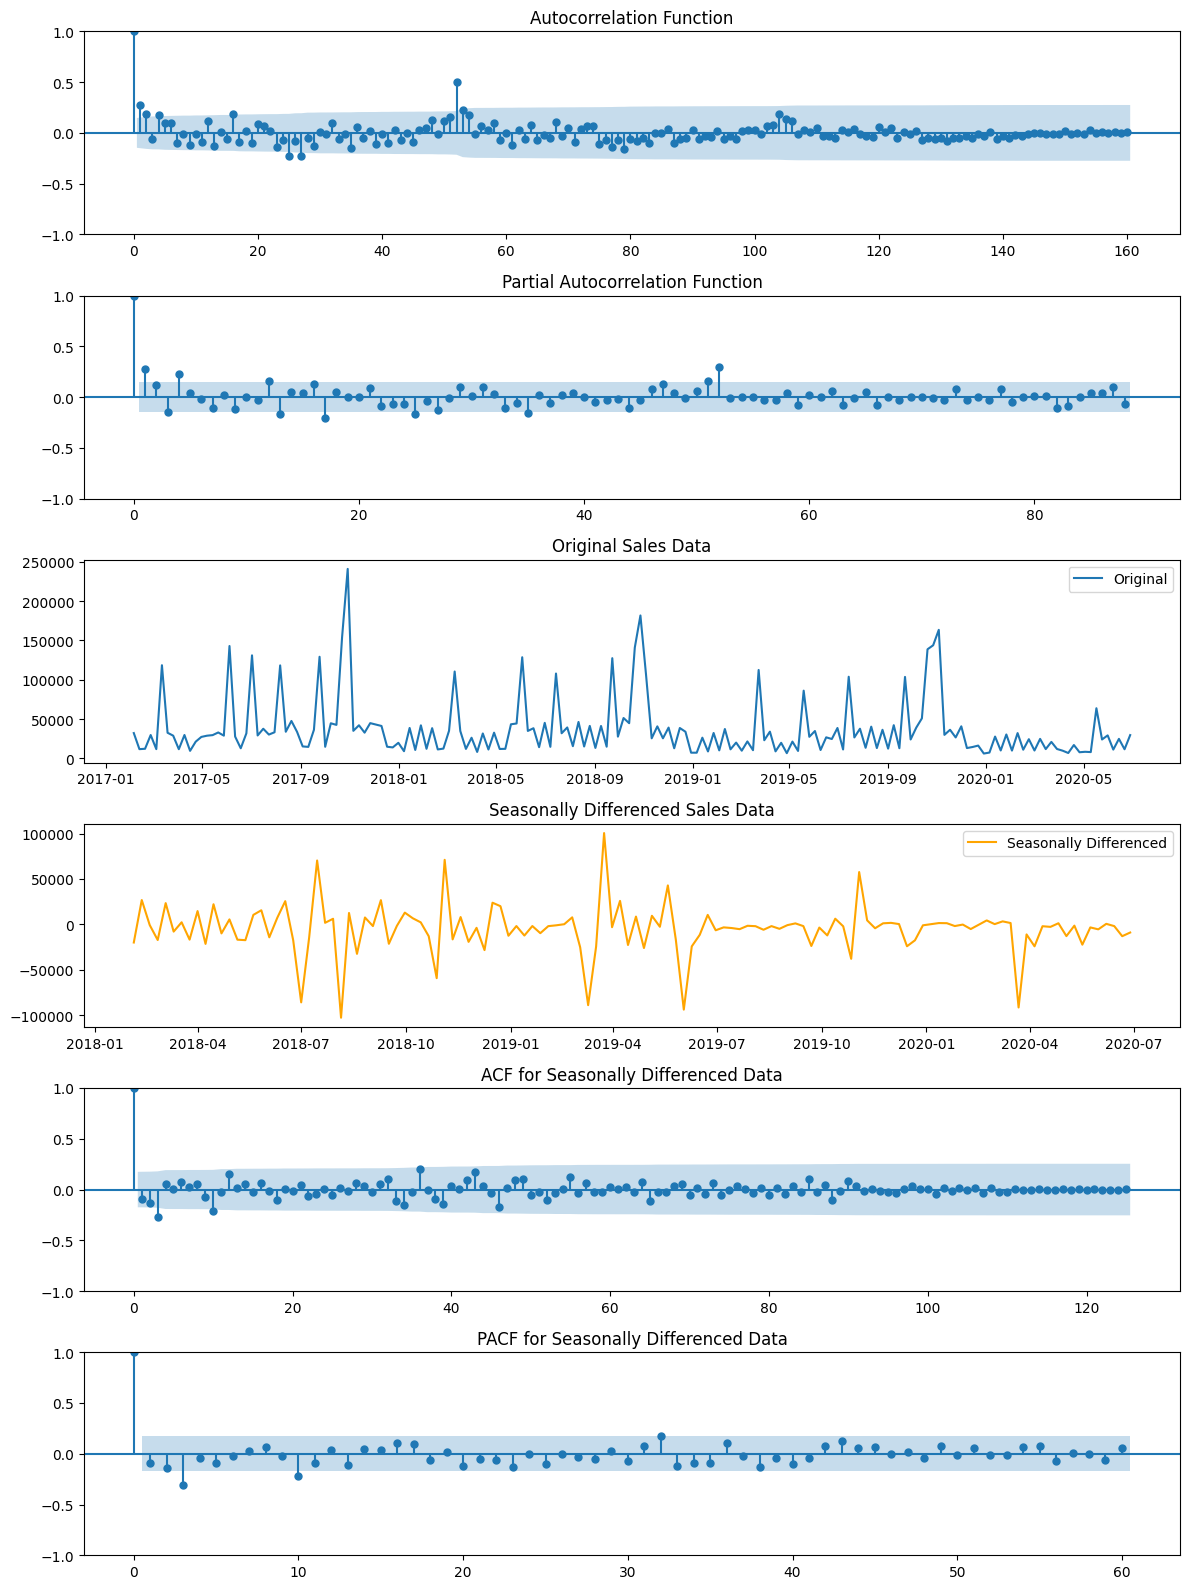

In [222]:
time_series_train_SKU6 = check_stationarity('SKU6')
# Stationary

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


ARIMA for SKU6 Forecast Accuracy: 0.5515141959335293


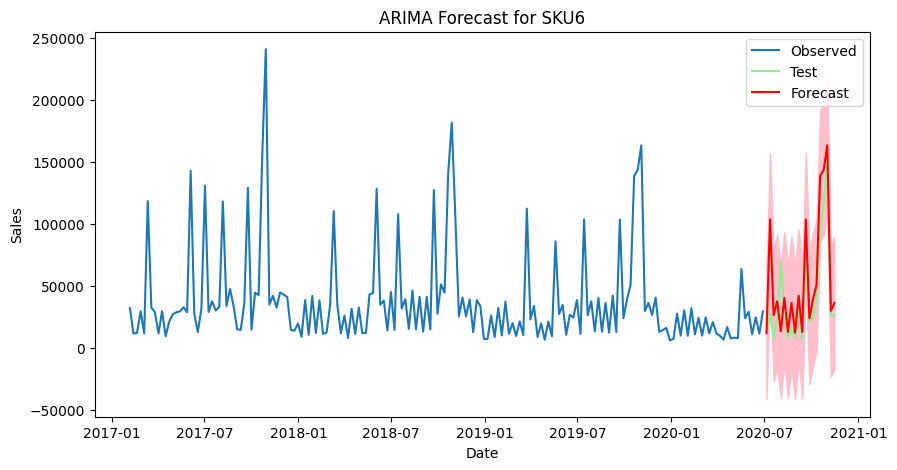

In [238]:
arima_SKU6 = arima_model(time_series_train_SKU6, 'SKU6', 1, 0, 0, 0, 1, 0, 52)

In [239]:
arima_SKU6

2020-07-05     11896.441198
2020-07-12    103787.675524
2020-07-19     26570.001098
2020-07-26     37662.792113
2020-08-02     13397.014400
2020-08-09     40294.999002
2020-08-16     13056.000069
2020-08-23     36293.999995
2020-08-30     12320.000000
2020-09-06     42182.000000
2020-09-13     12848.000000
2020-09-20    103617.000000
2020-09-27     23973.000000
2020-10-04     39082.000000
2020-10-11     50881.000000
2020-10-18    138789.000000
2020-10-25    143887.000000
2020-11-01    163536.000000
2020-11-08     29842.000000
2020-11-15     36323.000000
Freq: W-SUN, Name: predicted_mean, dtype: float64

# Forecast Plotting by Product

In [304]:
def plotting (product):
    time_series_pd = trainsform_train(product)
    time_series_test = trainsform_test(product)

# Fetch and prepare prediction data for different model
    lr_prediction = lr_predictions.filter(lr_predictions['Product'] == product).select("date", "prediction").orderBy("date")
    lr_prediction = lr_prediction.toPandas()
    lr_prediction.set_index('date', inplace=True)

    dt_prediction = dt_predictions.filter(dt_predictions['Product'] == product).select("date", "prediction").orderBy("date")
    dt_prediction = dt_prediction.toPandas()
    dt_prediction.set_index('date', inplace=True)

    gbt_prediction = gbt_predictions.filter(gbt_predictions['Product'] == product).select("date", "prediction").orderBy("date")
    gbt_prediction = gbt_prediction.toPandas()
    gbt_prediction.set_index('date', inplace=True)

    lstm_prediction = lstm_predictions[lstm_predictions['Product'] == product]
    lstm_prediction.set_index('date', inplace=True)

    arima_var = f'arima_{product}'
    arima_prediction = globals().get(arima_var)  # Access the ARIMA prediction object from global variables
    

# Visualize the forecast
    plt.figure(figsize=(15, 5))
    plt.plot(time_series_pd.index, time_series_pd['Sales'], label='Observed')
    plt.plot(time_series_test.index, time_series_test['Sales'], color='pink', linewidth=5, label='Test')
    plt.plot(lr_prediction.index, lr_prediction['prediction'], color='red', linewidth=2, label='Linear Regression')
    plt.plot(dt_prediction.index, dt_prediction['prediction'], color='orange', linewidth=2, label='Decision Tree')
    plt.plot(gbt_prediction.index, gbt_prediction['prediction'], color='purple', linewidth=0.8, label='Gradient-Boosted Trees')
    plt.plot(lstm_prediction.index, lstm_prediction['Predicted'], color='cyan', label='LSTM')
    plt.plot(arima_prediction.index, arima_prediction.values, color='olive', linewidth=0.8, label='ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Model Forecast for {product}')
    plt.legend()
    plt.savefig(f'Model Forecast for {product}.png')
    plt.show()

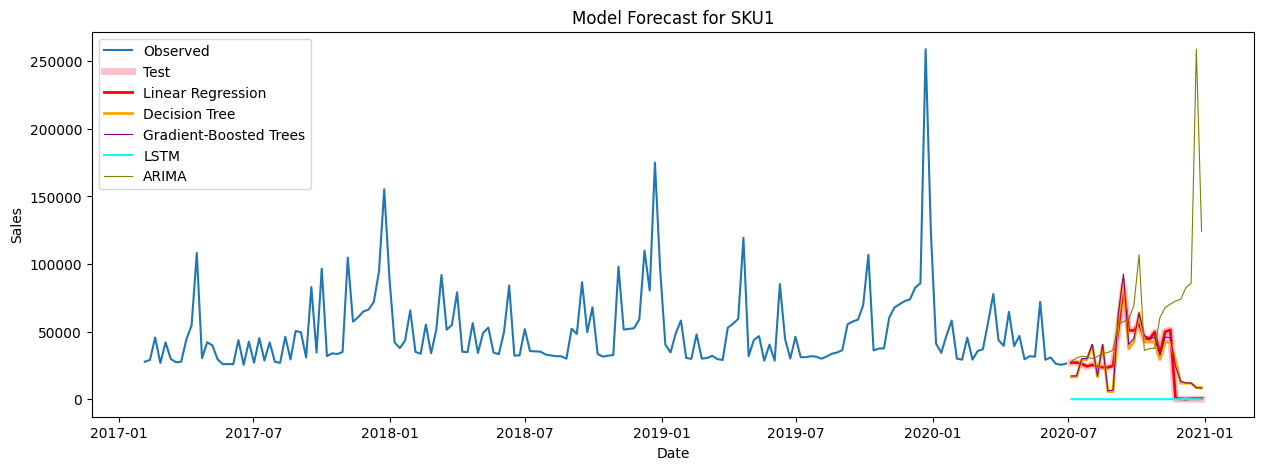

In [305]:
plotting('SKU1')

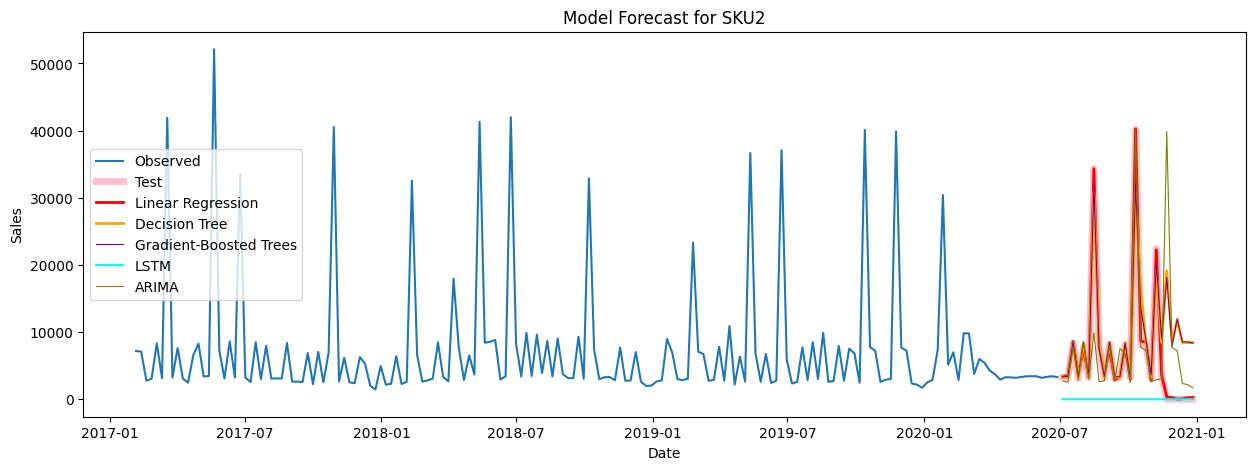

In [306]:
plotting('SKU2')

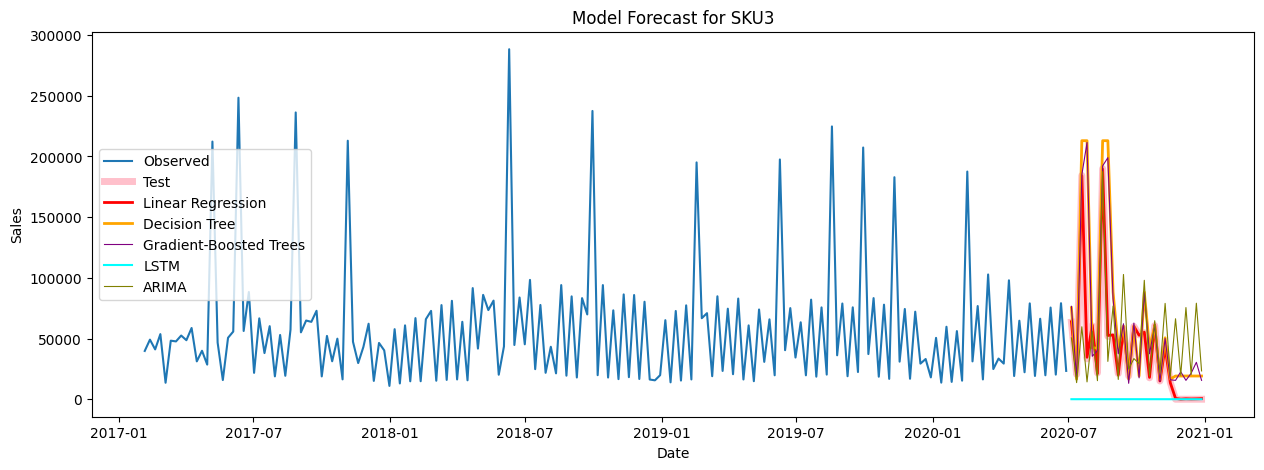

In [307]:
plotting('SKU3')

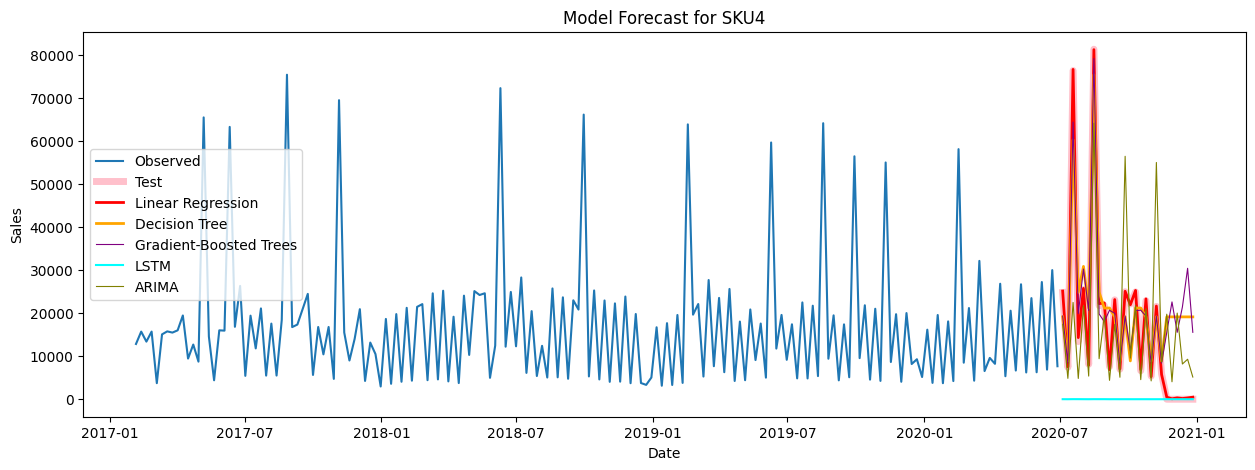

In [308]:
plotting('SKU4')

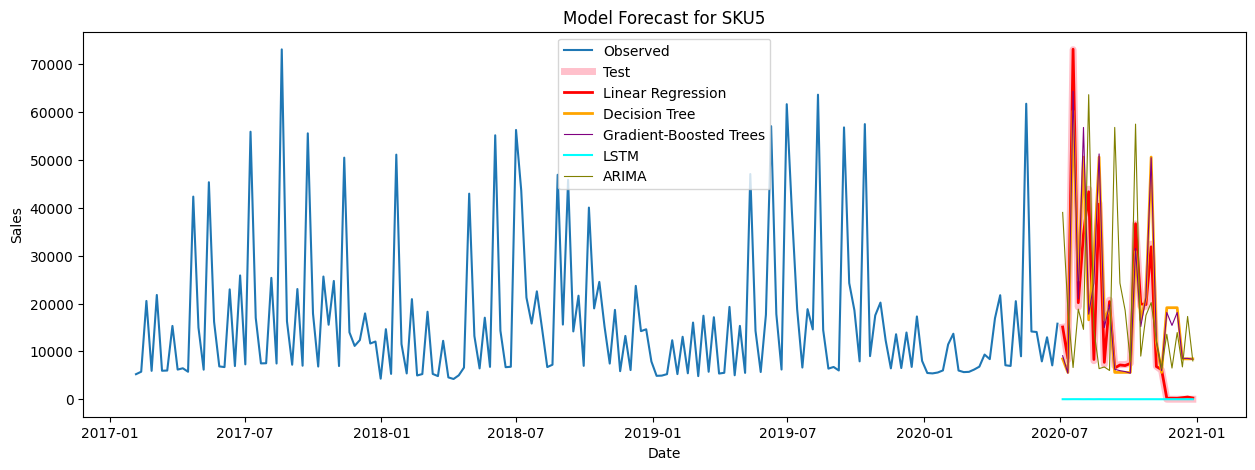

In [309]:
plotting('SKU5')

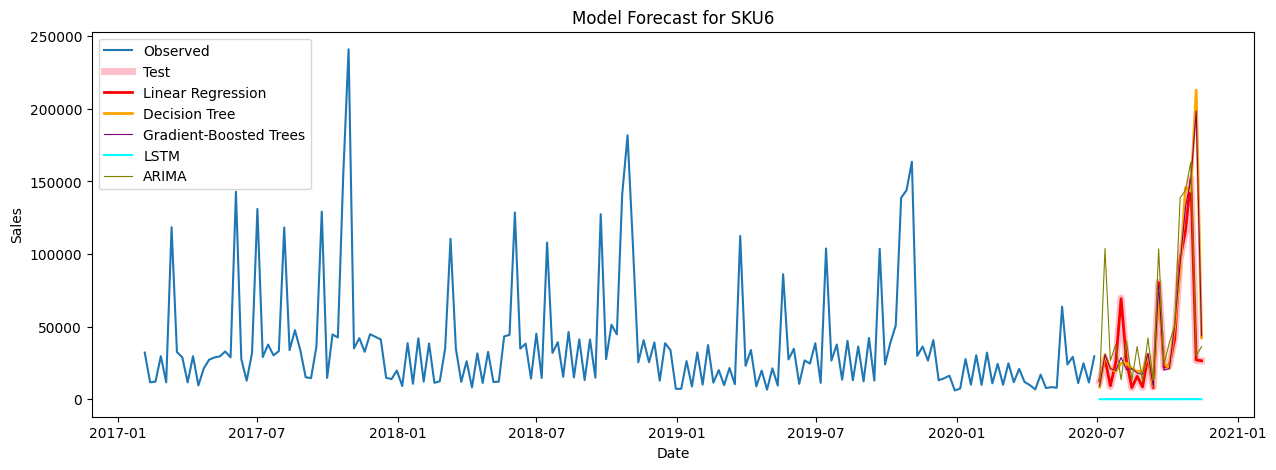

In [310]:
plotting('SKU6')